# Linear Regression- EDVANCER [Project 3]

### Using GradientRegressor and RandomForest

* Reading Data Set

In [1453]:
#pip install --user pandas-profiling
#pip install plotly
#pip install cufflinks
#plotly and cufflinks use for iplot

#LIME
#FeatureTools

In [1603]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import scale
from sklearn import metrics 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#from pandas_profiling import ProfileReport

# Changing working directory.

import os
path=os.getcwd()
new_path=os.chdir('D:\\Rishabh\\Python')

In [1604]:
train_data = pd.read_csv(r"D:\Rishabh\Python\P3 Data\counterfeit_train.csv")
test_data  = pd.read_csv(r"D:\Rishabh\Python\P3 Data\counterfeit_test.csv")

#train_data.head()
#test_data.head()

test_data['Counterfeit_Sales'] = np.nan

# In order to make columns arrangement similar for proper concatenation.
test_data = test_data[train_data.columns]

train_data['data'] = 'train'
test_data['data']  =  'test'

zscore_comp = np.abs(stats.zscore(train_data['Counterfeit_Sales']))

threshold=3
drp_idx = np.where(zscore_comp>threshold)[0]

train_data.drop(drp_idx, inplace=True)
#print(np.where(zscore_comp>threshold), len(drp_idx))

all_data = pd.concat([train_data, test_data], axis=0)
#all_data.describe()

* Pre-DEA

In [1605]:
# Gives number of missing values and unique values in columns
for col in all_data.columns:
    print("---------"+str(col)+"---------"+str(all_data[col].dtypes))
    print('Number of Unique value: '+str(all_data[col].nunique()))
    print('Number of missing value: '+str(all_data[col].isnull().sum()))

# OR
all_data.isnull().sum()

---------Medicine_ID---------object
Number of Unique value: 1557
Number of missing value: 0
---------Counterfeit_Weight---------float64
Number of Unique value: 415
Number of missing value: 1418
---------DistArea_ID---------object
Number of Unique value: 10
Number of missing value: 0
---------Active_Since---------int64
Number of Unique value: 9
Number of missing value: 0
---------Medicine_MRP---------float64
Number of Unique value: 5940
Number of missing value: 0
---------Medicine_Type---------object
Number of Unique value: 16
Number of missing value: 0
---------SidEffect_Level---------object
Number of Unique value: 2
Number of missing value: 0
---------Availability_rating---------float64
Number of Unique value: 7825
Number of missing value: 0
---------Area_Type---------object
Number of Unique value: 4
Number of missing value: 0
---------Area_City_Type---------object
Number of Unique value: 3
Number of missing value: 0
---------Area_dist_level---------object
Number of Unique value: 4
Nu

Medicine_ID               0
Counterfeit_Weight     1418
DistArea_ID               0
Active_Since              0
Medicine_MRP              0
Medicine_Type             0
SidEffect_Level           0
Availability_rating       0
Area_Type                 0
Area_City_Type            0
Area_dist_level           0
Counterfeit_Sales      1705
data                      0
dtype: int64

In [1606]:
##missing values of Counterfeit weight has been substituted with the weights of similar medicine type
impute_counter_wt_dict = all_data.groupby(['Medicine_ID'])['Counterfeit_Weight'].mean().to_dict()
for key, values in impute_counter_wt_dict.items():
    all_data.loc[all_data['Medicine_ID']==key, 'Counterfeit_Weight'] = np.round(values)

all_data.drop(all_data[all_data['Counterfeit_Weight'].isna()].index ,  inplace=True)

Even after removing some of outliers the data is still skewed, will handle this with Robust Scaler as this uses std deviation for scaling data points which gives better results when the feature is having some outliers.

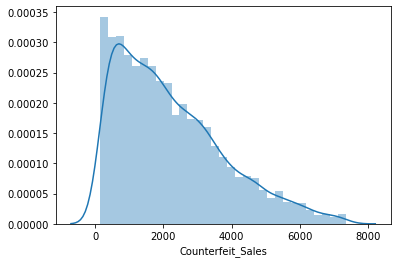

In [1607]:
sns.distplot(train_data['Counterfeit_Sales'])

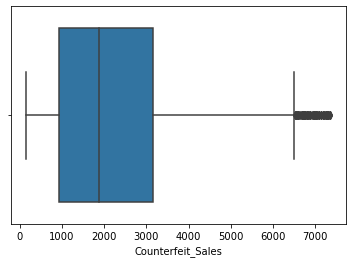

In [1608]:
sns.boxplot(x=train_data['Counterfeit_Sales'])

Bivariate analysis of Medicine MRp ,which shows some linear relation with target variable

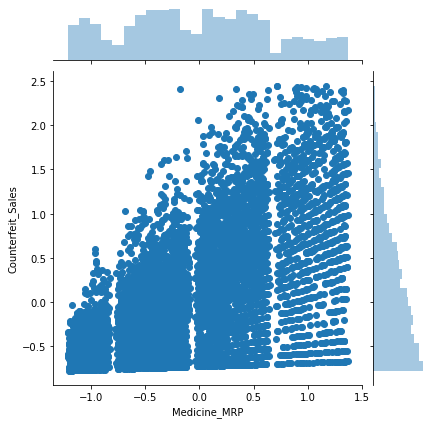

In [1640]:
sns.jointplot(x='Medicine_MRP', y='Counterfeit_Sales', data=all_data)

Here we will discretize data of continuous variables, basically splitting cont data into number of bins

In [1609]:
##Discretizing numerical data
from sklearn.preprocessing import KBinsDiscretizer

availability_disctriz = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
all_data['Availability_rating_bins'] = kbins.fit_transform(all_data['Availability_rating'].values.reshape(-1,1)).astype(int)

cols_to_disc      = ['Counterfeit_Weight','Medicine_MRP']
cols_to_disc_bins = ['Counterfeit_Weight_bins','Medicine_MRP_bins']
disctriz = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

all_data[cols_to_disc_bins] = all_data[cols_to_disc]
all_data[cols_to_disc_bins] = kbins.fit_transform(all_data[cols_to_disc]).astype(int)

#all_data.drop(cols_to_disc ,axis=1 ,inplace=True)
#del all_data['Availability_rating']

Finding Correlation

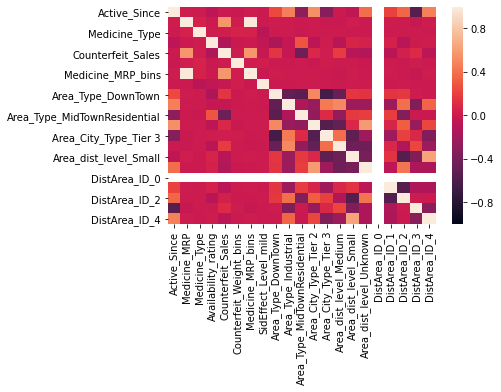

In [1638]:
sns.heatmap(all_data.corr(), vmin=-1, vmax=1)

Below function just evaluates the results with diffrent kind of scaling method and normalizer
Standard scaler, Robust scaler and MinMax scaler

In [1610]:
def results_of_diff_scaling(df):
    itr=1
    cols_to_std        = ['Counterfeit_Weight','Medicine_MRP', 'Active_Since','Availability_rating','Availability_rating_bins','Counterfeit_Weight_bins','Medicine_MRP_bins']
    target_scaling     = ['Counterfeit_Sales']
    
    '''
    Produces result with std scaler, normalizer, robust scaler
    itr==1 --> std scaler
    itr==2 --> MinMaxScaler
    itr==3 --> RobustScaler
    '''
    while (True):
        all_data_scale=all_data.copy()
        trainData = all_data_scale[all_data_scale['data'] =='train'].copy()
        testData  = all_data_scale[all_data_scale['data'] =='test'].copy()
        
        if itr==1:
            print("\nStandard Scaling Result...\n")            
            stdScale   = StandardScaler().fit(trainData[cols_to_std])
            trgt_scale = StandardScaler().fit(trainData[target_scaling])
            
            trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
            trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])
            
            testData[cols_to_std] = stdScale.transform(testData[cols_to_std])
            
            all_data_scale = pd.concat([trainData, testData], axis=0)
            
            x_train = all_data_scale[all_data_scale['data'] =='train'].copy()
            y_train = x_train['Counterfeit_Sales']
            x_train = x_train.drop(['Counterfeit_Sales', 'data'], axis=1)

            x_test  = all_data_scale[all_data_scale['data'] =='test'].copy()
            x_test  = x_test.drop(['Counterfeit_Sales', 'data'], axis=1)

            train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)
            
            xgb_rs_best.fit(train_d, train_dd)
            
            rf=RandomForestRegressor(n_estimators=800,criterion='mse',max_depth=6,bootstrap=True,min_samples_split=2)
            rf.fit(train_d, train_dd)
            
            predicted_val = xgb_rs_best.predict(test_d)
            predicted_val_rf = rf.predict(test_d)
            
            predicted_val = trgt_scale.inverse_transform(np.array(predicted_val).reshape(-1,1))
            predicted_val_rf = trgt_scale.inverse_transform(np.array(predicted_val_rf).reshape(-1,1))
            test_dd       = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
            
            #predicted_val    = np.exp(predicted_val)
            #predicted_val_rf = np.exp(predicted_val_rf)
            #test_dd          = np.exp(test_dd)

            MAE = mean_absolute_error(test_dd, predicted_val)
            #Calculating Score
            Score = 1-(MAE/1660)
            r2score = r2_score(test_dd,predicted_val)
            
            print("\nGD : Score : {0} and MeanAbsError {1} and R2 Score {2}".format(Score , MAE, r2score))
            
            MAE_rf = mean_absolute_error(test_dd, predicted_val_rf)
            #Calculating Score
            Score_rf = 1-(MAE_rf/1660)
            
            r2score_rf = r2_score(test_dd,predicted_val_rf)
            
            print("\nRF : Score : {0} and MeanAbsError {1} and R2 Score {2}".format(Score_rf , MAE_rf, r2score_rf))
            
        if itr==2:
            print("\nNormalizing Result...\n")            
            stdScale   = MinMaxScaler().fit(trainData[cols_to_std])
            trgt_scale = MinMaxScaler().fit(trainData[target_scaling])
            
            trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
            trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])
            
            testData[cols_to_std] = stdScale.transform(testData[cols_to_std])
            
            all_data_scale = pd.concat([trainData, testData], axis=0)
            
            x_train = all_data_scale[all_data_scale['data'] =='train'].copy()
            y_train = x_train['Counterfeit_Sales']
            x_train = x_train.drop(['Counterfeit_Sales', 'data'], axis=1)

            x_test  = all_data_scale[all_data_scale['data'] =='test'].copy()
            x_test  = x_test.drop(['Counterfeit_Sales', 'data'], axis=1)

            train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)
            
            xgb_rs_best.fit(train_d, train_dd)
            predicted_val = xgb_rs_best.predict(test_d)
            
            predicted_val = trgt_scale.inverse_transform(np.array(predicted_val).reshape(-1,1))
            test_dd       = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
            
            #predicted_val = np.exp(predicted_val)
            #test_dd       = np.exp(test_dd)

            MAE = mean_absolute_error(test_dd, predicted_val)
            #Calculating Score
            Score = 1-(MAE/1660)
            r2score = r2_score(test_dd,predicted_val)
            
            print("\nGD : Score : {0} and MeanAbsError {1} and R2 Score {2}".format(Score , MAE, r2score))


        if itr==3:
            print("\nRobust Scaling Result...\n")            
            stdScale   = RobustScaler().fit(trainData[cols_to_std])
            trgt_scale = RobustScaler().fit(trainData[target_scaling])
            
            trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
            trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])
            
            testData[cols_to_std] = stdScale.transform(testData[cols_to_std])
            
            all_data_scale = pd.concat([trainData, testData], axis=0)
            
            x_train = all_data_scale[all_data_scale['data'] =='train'].copy()
            y_train = x_train['Counterfeit_Sales']
            x_train = x_train.drop(['Counterfeit_Sales', 'data'], axis=1)

            x_test  = all_data_scale[all_data_scale['data'] =='test'].copy()
            x_test  = x_test.drop(['Counterfeit_Sales', 'data'], axis=1)

            train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)
            
            xgb_rs_best.fit(train_d, train_dd)
            predicted_val = xgb_rs_best.predict(test_d)
            
            rf=RandomForestRegressor(n_estimators=600,criterion='mse',max_depth=6,bootstrap=True,min_samples_split=2)
            rf.fit(train_d, train_dd)            
            predicted_val_rf = rf.predict(test_d)
            
            predicted_val = trgt_scale.inverse_transform(np.array(predicted_val).reshape(-1,1))
            predicted_val_rf = trgt_scale.inverse_transform(np.array(predicted_val_rf).reshape(-1,1))
            test_dd       = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
            
            #predicted_val = np.exp(predicted_val)
            #test_dd       = np.exp(test_dd)
            
            MAE = mean_absolute_error(test_dd, predicted_val)
            #Calculating Score
            Score = 1-(MAE/1660)
            r2score = r2_score(test_dd,predicted_val)
            
            print("\nGD : Score : {0} and MeanAbsError {1} and R2 Score {2}".format(Score , MAE, r2score))

            MAE_rf = mean_absolute_error(test_dd, predicted_val_rf)
            #Calculating Score
            Score_rf = 1-(MAE_rf/1660)
            
            r2score_rf = r2_score(test_dd,predicted_val_rf)
            
            print("\nRF : Score : {0} and MeanAbsError {1} and R2 Score {2}".format(Score_rf , MAE_rf, r2score_rf))
        
        if itr > 3:
            break
            
        itr = itr+1

Encoding of categorical data

In [1611]:
#GEt dummies
col_to_crt_dummy=['SidEffect_Level', 'Area_Type', 'Area_City_Type', 'Area_dist_level']
for cat_col in col_to_crt_dummy:
    dummy_col = pd.get_dummies(all_data[cat_col], drop_first=True, prefix=cat_col)
    all_data  = pd.concat([all_data , dummy_col], axis=1, ignore_index=False)
    del all_data[cat_col]

#Encoding
#DistArea_ID , Medicine_Type
import category_encoders as ce

all_data['DistArea_ID'] = all_data['DistArea_ID'].replace('Area', '')
be = ce.BinaryEncoder(cols=['DistArea_ID'])
cityCodes = be.fit_transform(all_data['DistArea_ID'] , all_data['Counterfeit_Sales'])
all_data  = pd.concat([all_data, cityCodes] , axis=1)

#del all_data['DistArea_ID_0']
medicine_type_enc = all_data['Medicine_Type'].value_counts().to_dict()
all_data['Medicine_Type'] = all_data['Medicine_Type'].replace(medicine_type_enc)

all_data.drop(['Medicine_ID'], axis=1,inplace=True)
all_data.drop(['DistArea_ID'], axis=1,inplace=True)
#all_data.drop(['Active_Since'],axis=1,inplace=True)
#all_data.drop('Medicine_Type', axis=1, inplace=True)

In [1469]:
results_of_diff_scaling(all_data)


Standard Scaling Result...


GD : Score : 0.5507865500382281 and MeanAbsError 745.6943269365415 and R2 Score 0.5529904566910109

RF : Score : 0.5560236781614771 and MeanAbsError 737.000694251948 and R2 Score 0.5605896093551084

Normalizing Result...


GD : Score : 0.5668059449362772 and MeanAbsError 719.1021314057798 and R2 Score 0.5873603872045218

Robust Scaling Result...


GD : Score : 0.5583471122740964 and MeanAbsError 733.143793625 and R2 Score 0.5906856901970283

RF : Score : 0.5627678190010872 and MeanAbsError 725.8054204581953 and R2 Score 0.5948629155381124


In [1612]:
##Standerdizing data with robust scaler
##Robust scaler deals with the deviations in data

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

cols_to_std = cols_to_std        = ['Counterfeit_Weight','Medicine_MRP', 'Active_Since', 'Availability_rating','Availability_rating_bins','Counterfeit_Weight_bins','Medicine_MRP_bins']
target_scaling                   = ['Counterfeit_Sales']

trainData = all_data[all_data['data'] =='train'].copy()
testData  = all_data[all_data['data'] =='test'].copy()

stdScale   = RobustScaler().fit(trainData[cols_to_std])
trgt_scale = RobustScaler().fit(trainData[target_scaling])

trainData[cols_to_std]    = stdScale.transform(trainData[cols_to_std])
testData[cols_to_std]     = stdScale.transform(testData[cols_to_std])

trainData[target_scaling] = trgt_scale.transform(trainData[target_scaling])

all_data = pd.concat([trainData, testData], axis=0)

In [1618]:
#Two variables dropped after feature engg.
all_data.drop(['Counterfeit_Weight', 'Availability_rating_bins'] ,axis=1, inplace=True)

x_train = all_data[all_data['data'] =='train'].copy()

y_train = x_train['Counterfeit_Sales']
x_train = x_train.drop(['Counterfeit_Sales', 'data'], axis=1)

x_test = all_data[all_data['data'] =='test'].copy()
x_test  = x_test.drop(['Counterfeit_Sales', 'data'], axis=1)

train_d, test_d, train_dd, test_dd = train_test_split(x_train , y_train , test_size = 0.2)

test_dd_invtrf  = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))
train_dd_invtrf = trgt_scale.inverse_transform(np.array(train_dd).reshape(-1,1))

In [1619]:
all_data.shape

(8452, 22)

In [1539]:
##XGboost
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error, mean_squared_error

xgb_r = xg.XGBRegressor(eval_metric = 'mae') 

param_test_xgb = {
 'max_depth'       :[4,5,6],
 'min_child_weight':[0,1,2],
 'gamma'           :[0, 0.1,0.2],
 'reg_alpha'       :[0.1, 0.01, 0.05],
 'reg_lambda'      :[0.1, 0.01, 0.05],
 'colsample_bytree'  :[0.7],
 'learning_rate'     : [.03, 0.02, 0.01],
 'n_estimators'   : [700,850,1000]
}

xgb_rs = RandomizedSearchCV(xgb_r , param_distributions=param_test_xgb, cv=5, n_iter=10, scoring='neg_mean_absolute_error')

xgb_rs.fit(train_d, train_dd, early_stopping_rounds=7, eval_set =[(train_d, train_dd), (test_d, test_dd)]) 
  
pred     = xgb_rs.predict(train_d) 
pred     = trgt_scale.inverse_transform(np.array(pred).reshape(-1,1))

# RMSE Computation 
rmse = np.sqrt(MSE(train_dd_invtrf, pred)) 
print("Train RMSE : % f" %(rmse)) 

pred_test = xgb_rs.predict(test_d) 
pred_test = trgt_scale.inverse_transform(np.array(pred_test).reshape(-1,1))

rmse = np.sqrt(MSE(test_dd_invtrf, pred_test)) 
print("Test RMSE : % f" %(rmse)) 

[0]	validation_0-mae:0.67371	validation_1-mae:0.64820
[1]	validation_0-mae:0.66512	validation_1-mae:0.64009
[2]	validation_0-mae:0.65667	validation_1-mae:0.63207
[3]	validation_0-mae:0.64840	validation_1-mae:0.62419
[4]	validation_0-mae:0.64387	validation_1-mae:0.61954
[5]	validation_0-mae:0.63679	validation_1-mae:0.61286
[6]	validation_0-mae:0.62937	validation_1-mae:0.60592
[7]	validation_0-mae:0.62513	validation_1-mae:0.60157
[8]	validation_0-mae:0.61764	validation_1-mae:0.59449
[9]	validation_0-mae:0.61063	validation_1-mae:0.58784
[10]	validation_0-mae:0.60701	validation_1-mae:0.58416
[11]	validation_0-mae:0.60132	validation_1-mae:0.57903
[12]	validation_0-mae:0.59463	validation_1-mae:0.57267
[13]	validation_0-mae:0.58781	validation_1-mae:0.56626
[14]	validation_0-mae:0.58149	validation_1-mae:0.56047
[15]	validation_0-mae:0.57531	validation_1-mae:0.55468
[16]	validation_0-mae:0.57022	validation_1-mae:0.54997
[17]	validation_0-mae:0.56398	validation_1-mae:0.54412
[18]	validation_0-ma

[149]	validation_0-mae:0.32396	validation_1-mae:0.32697
[150]	validation_0-mae:0.32372	validation_1-mae:0.32681
[151]	validation_0-mae:0.32348	validation_1-mae:0.32656
[152]	validation_0-mae:0.32320	validation_1-mae:0.32636
[153]	validation_0-mae:0.32290	validation_1-mae:0.32615
[154]	validation_0-mae:0.32266	validation_1-mae:0.32598
[155]	validation_0-mae:0.32240	validation_1-mae:0.32581
[156]	validation_0-mae:0.32218	validation_1-mae:0.32562
[157]	validation_0-mae:0.32198	validation_1-mae:0.32554
[158]	validation_0-mae:0.32171	validation_1-mae:0.32526
[159]	validation_0-mae:0.32152	validation_1-mae:0.32517
[160]	validation_0-mae:0.32132	validation_1-mae:0.32512
[161]	validation_0-mae:0.32109	validation_1-mae:0.32494
[162]	validation_0-mae:0.32086	validation_1-mae:0.32482
[163]	validation_0-mae:0.32061	validation_1-mae:0.32466
[164]	validation_0-mae:0.32046	validation_1-mae:0.32458
[165]	validation_0-mae:0.32032	validation_1-mae:0.32453
[166]	validation_0-mae:0.32014	validation_1-mae:

[38]	validation_0-mae:0.47048	validation_1-mae:0.45693
[39]	validation_0-mae:0.46659	validation_1-mae:0.45329
[40]	validation_0-mae:0.46283	validation_1-mae:0.44989
[41]	validation_0-mae:0.46062	validation_1-mae:0.44770
[42]	validation_0-mae:0.45731	validation_1-mae:0.44481
[43]	validation_0-mae:0.45428	validation_1-mae:0.44205
[44]	validation_0-mae:0.45093	validation_1-mae:0.43904
[45]	validation_0-mae:0.44760	validation_1-mae:0.43603
[46]	validation_0-mae:0.44435	validation_1-mae:0.43310
[47]	validation_0-mae:0.44172	validation_1-mae:0.43077
[48]	validation_0-mae:0.43979	validation_1-mae:0.42884
[49]	validation_0-mae:0.43668	validation_1-mae:0.42599
[50]	validation_0-mae:0.43424	validation_1-mae:0.42387
[51]	validation_0-mae:0.43133	validation_1-mae:0.42129
[52]	validation_0-mae:0.42838	validation_1-mae:0.41861
[53]	validation_0-mae:0.42555	validation_1-mae:0.41605
[54]	validation_0-mae:0.42279	validation_1-mae:0.41353
[55]	validation_0-mae:0.42066	validation_1-mae:0.41174
[56]	valid

[186]	validation_0-mae:0.31712	validation_1-mae:0.32127
[187]	validation_0-mae:0.31701	validation_1-mae:0.32131
[188]	validation_0-mae:0.31686	validation_1-mae:0.32119
[189]	validation_0-mae:0.31674	validation_1-mae:0.32107
[190]	validation_0-mae:0.31662	validation_1-mae:0.32106
[191]	validation_0-mae:0.31652	validation_1-mae:0.32102
[192]	validation_0-mae:0.31639	validation_1-mae:0.32091
[193]	validation_0-mae:0.31627	validation_1-mae:0.32095
[194]	validation_0-mae:0.31616	validation_1-mae:0.32089
[195]	validation_0-mae:0.31607	validation_1-mae:0.32089
[196]	validation_0-mae:0.31596	validation_1-mae:0.32084
[197]	validation_0-mae:0.31583	validation_1-mae:0.32081
[198]	validation_0-mae:0.31573	validation_1-mae:0.32075
[199]	validation_0-mae:0.31563	validation_1-mae:0.32075
[200]	validation_0-mae:0.31551	validation_1-mae:0.32067
[201]	validation_0-mae:0.31543	validation_1-mae:0.32065
[202]	validation_0-mae:0.31531	validation_1-mae:0.32056
[203]	validation_0-mae:0.31520	validation_1-mae:

[85]	validation_0-mae:0.36402	validation_1-mae:0.36047
[86]	validation_0-mae:0.36306	validation_1-mae:0.35967
[87]	validation_0-mae:0.36212	validation_1-mae:0.35884
[88]	validation_0-mae:0.36082	validation_1-mae:0.35763
[89]	validation_0-mae:0.35959	validation_1-mae:0.35654
[90]	validation_0-mae:0.35834	validation_1-mae:0.35544
[91]	validation_0-mae:0.35734	validation_1-mae:0.35459
[92]	validation_0-mae:0.35612	validation_1-mae:0.35350
[93]	validation_0-mae:0.35495	validation_1-mae:0.35245
[94]	validation_0-mae:0.35383	validation_1-mae:0.35145
[95]	validation_0-mae:0.35302	validation_1-mae:0.35072
[96]	validation_0-mae:0.35192	validation_1-mae:0.34972
[97]	validation_0-mae:0.35119	validation_1-mae:0.34913
[98]	validation_0-mae:0.35047	validation_1-mae:0.34842
[99]	validation_0-mae:0.34947	validation_1-mae:0.34751
[100]	validation_0-mae:0.34847	validation_1-mae:0.34660
[101]	validation_0-mae:0.34753	validation_1-mae:0.34571
[102]	validation_0-mae:0.34688	validation_1-mae:0.34522
[103]	v

[232]	validation_0-mae:0.31249	validation_1-mae:0.31792
[233]	validation_0-mae:0.31244	validation_1-mae:0.31789
[234]	validation_0-mae:0.31239	validation_1-mae:0.31785
[235]	validation_0-mae:0.31232	validation_1-mae:0.31787
[236]	validation_0-mae:0.31222	validation_1-mae:0.31783
[237]	validation_0-mae:0.31215	validation_1-mae:0.31787
[238]	validation_0-mae:0.31211	validation_1-mae:0.31784
[239]	validation_0-mae:0.31203	validation_1-mae:0.31790
[240]	validation_0-mae:0.31195	validation_1-mae:0.31789
[241]	validation_0-mae:0.31190	validation_1-mae:0.31786
[242]	validation_0-mae:0.31186	validation_1-mae:0.31783
[243]	validation_0-mae:0.31181	validation_1-mae:0.31782
[244]	validation_0-mae:0.31177	validation_1-mae:0.31778
[245]	validation_0-mae:0.31169	validation_1-mae:0.31784
[246]	validation_0-mae:0.31165	validation_1-mae:0.31781
[247]	validation_0-mae:0.31160	validation_1-mae:0.31779
[248]	validation_0-mae:0.31153	validation_1-mae:0.31786
[249]	validation_0-mae:0.31145	validation_1-mae:

[129]	validation_0-mae:0.33147	validation_1-mae:0.33149
[130]	validation_0-mae:0.33102	validation_1-mae:0.33109
[131]	validation_0-mae:0.33057	validation_1-mae:0.33070
[132]	validation_0-mae:0.33024	validation_1-mae:0.33053
[133]	validation_0-mae:0.32979	validation_1-mae:0.33014
[134]	validation_0-mae:0.32938	validation_1-mae:0.32977
[135]	validation_0-mae:0.32899	validation_1-mae:0.32943
[136]	validation_0-mae:0.32860	validation_1-mae:0.32910
[137]	validation_0-mae:0.32822	validation_1-mae:0.32878
[138]	validation_0-mae:0.32784	validation_1-mae:0.32843
[139]	validation_0-mae:0.32759	validation_1-mae:0.32825
[140]	validation_0-mae:0.32733	validation_1-mae:0.32811
[141]	validation_0-mae:0.32699	validation_1-mae:0.32781
[142]	validation_0-mae:0.32666	validation_1-mae:0.32749
[143]	validation_0-mae:0.32639	validation_1-mae:0.32722
[144]	validation_0-mae:0.32606	validation_1-mae:0.32694
[145]	validation_0-mae:0.32585	validation_1-mae:0.32678
[146]	validation_0-mae:0.32554	validation_1-mae:

[35]	validation_0-mae:0.48059	validation_1-mae:0.46729
[36]	validation_0-mae:0.47704	validation_1-mae:0.46415
[37]	validation_0-mae:0.47465	validation_1-mae:0.46176
[38]	validation_0-mae:0.47065	validation_1-mae:0.45809
[39]	validation_0-mae:0.46672	validation_1-mae:0.45454
[40]	validation_0-mae:0.46295	validation_1-mae:0.45115
[41]	validation_0-mae:0.46075	validation_1-mae:0.44894
[42]	validation_0-mae:0.45783	validation_1-mae:0.44626
[43]	validation_0-mae:0.45489	validation_1-mae:0.44368
[44]	validation_0-mae:0.45150	validation_1-mae:0.44066
[45]	validation_0-mae:0.44813	validation_1-mae:0.43759
[46]	validation_0-mae:0.44484	validation_1-mae:0.43459
[47]	validation_0-mae:0.44220	validation_1-mae:0.43226
[48]	validation_0-mae:0.44024	validation_1-mae:0.43031
[49]	validation_0-mae:0.43708	validation_1-mae:0.42745
[50]	validation_0-mae:0.43463	validation_1-mae:0.42530
[51]	validation_0-mae:0.43168	validation_1-mae:0.42257
[52]	validation_0-mae:0.42869	validation_1-mae:0.41984
[53]	valid

[183]	validation_0-mae:0.31727	validation_1-mae:0.32225
[184]	validation_0-mae:0.31712	validation_1-mae:0.32212
[185]	validation_0-mae:0.31697	validation_1-mae:0.32199
[186]	validation_0-mae:0.31683	validation_1-mae:0.32186
[187]	validation_0-mae:0.31668	validation_1-mae:0.32174
[188]	validation_0-mae:0.31655	validation_1-mae:0.32162
[189]	validation_0-mae:0.31643	validation_1-mae:0.32150
[190]	validation_0-mae:0.31630	validation_1-mae:0.32144
[191]	validation_0-mae:0.31616	validation_1-mae:0.32140
[192]	validation_0-mae:0.31605	validation_1-mae:0.32134
[193]	validation_0-mae:0.31598	validation_1-mae:0.32136
[194]	validation_0-mae:0.31588	validation_1-mae:0.32135
[195]	validation_0-mae:0.31579	validation_1-mae:0.32132
[196]	validation_0-mae:0.31568	validation_1-mae:0.32119
[197]	validation_0-mae:0.31559	validation_1-mae:0.32116
[198]	validation_0-mae:0.31547	validation_1-mae:0.32121
[199]	validation_0-mae:0.31534	validation_1-mae:0.32118
[200]	validation_0-mae:0.31523	validation_1-mae:

[77]	validation_0-mae:0.33752	validation_1-mae:0.33843
[78]	validation_0-mae:0.33678	validation_1-mae:0.33773
[79]	validation_0-mae:0.33583	validation_1-mae:0.33696
[80]	validation_0-mae:0.33490	validation_1-mae:0.33617
[81]	validation_0-mae:0.33403	validation_1-mae:0.33541
[82]	validation_0-mae:0.33320	validation_1-mae:0.33469
[83]	validation_0-mae:0.33240	validation_1-mae:0.33393
[84]	validation_0-mae:0.33160	validation_1-mae:0.33323
[85]	validation_0-mae:0.33090	validation_1-mae:0.33263
[86]	validation_0-mae:0.33034	validation_1-mae:0.33220
[87]	validation_0-mae:0.32979	validation_1-mae:0.33180
[88]	validation_0-mae:0.32911	validation_1-mae:0.33114
[89]	validation_0-mae:0.32850	validation_1-mae:0.33064
[90]	validation_0-mae:0.32787	validation_1-mae:0.33009
[91]	validation_0-mae:0.32739	validation_1-mae:0.32972
[92]	validation_0-mae:0.32676	validation_1-mae:0.32911
[93]	validation_0-mae:0.32616	validation_1-mae:0.32857
[94]	validation_0-mae:0.32564	validation_1-mae:0.32810
[95]	valid

[25]	validation_0-mae:0.47293	validation_1-mae:0.45896
[26]	validation_0-mae:0.46700	validation_1-mae:0.45355
[27]	validation_0-mae:0.46156	validation_1-mae:0.44859
[28]	validation_0-mae:0.45606	validation_1-mae:0.44358
[29]	validation_0-mae:0.45075	validation_1-mae:0.43875
[30]	validation_0-mae:0.44575	validation_1-mae:0.43426
[31]	validation_0-mae:0.44151	validation_1-mae:0.43053
[32]	validation_0-mae:0.43711	validation_1-mae:0.42643
[33]	validation_0-mae:0.43288	validation_1-mae:0.42249
[34]	validation_0-mae:0.42838	validation_1-mae:0.41831
[35]	validation_0-mae:0.42488	validation_1-mae:0.41515
[36]	validation_0-mae:0.42119	validation_1-mae:0.41170
[37]	validation_0-mae:0.41865	validation_1-mae:0.40921
[38]	validation_0-mae:0.41467	validation_1-mae:0.40549
[39]	validation_0-mae:0.41085	validation_1-mae:0.40193
[40]	validation_0-mae:0.40718	validation_1-mae:0.39862
[41]	validation_0-mae:0.40494	validation_1-mae:0.39642
[42]	validation_0-mae:0.40186	validation_1-mae:0.39372
[43]	valid

[22]	validation_0-mae:0.49224	validation_1-mae:0.47680
[23]	validation_0-mae:0.48582	validation_1-mae:0.47106
[24]	validation_0-mae:0.47936	validation_1-mae:0.46524
[25]	validation_0-mae:0.47308	validation_1-mae:0.45952
[26]	validation_0-mae:0.46701	validation_1-mae:0.45408
[27]	validation_0-mae:0.46143	validation_1-mae:0.44913
[28]	validation_0-mae:0.45582	validation_1-mae:0.44402
[29]	validation_0-mae:0.45045	validation_1-mae:0.43913
[30]	validation_0-mae:0.44531	validation_1-mae:0.43459
[31]	validation_0-mae:0.44117	validation_1-mae:0.43072
[32]	validation_0-mae:0.43631	validation_1-mae:0.42629
[33]	validation_0-mae:0.43170	validation_1-mae:0.42204
[34]	validation_0-mae:0.42706	validation_1-mae:0.41788
[35]	validation_0-mae:0.42339	validation_1-mae:0.41454
[36]	validation_0-mae:0.41969	validation_1-mae:0.41108
[37]	validation_0-mae:0.41714	validation_1-mae:0.40858
[38]	validation_0-mae:0.41301	validation_1-mae:0.40489
[39]	validation_0-mae:0.40906	validation_1-mae:0.40134
[40]	valid

[13]	validation_0-mae:0.54904	validation_1-mae:0.52956
[14]	validation_0-mae:0.54079	validation_1-mae:0.52197
[15]	validation_0-mae:0.53275	validation_1-mae:0.51458
[16]	validation_0-mae:0.52589	validation_1-mae:0.50849
[17]	validation_0-mae:0.51799	validation_1-mae:0.50125
[18]	validation_0-mae:0.51142	validation_1-mae:0.49521
[19]	validation_0-mae:0.50722	validation_1-mae:0.49105
[20]	validation_0-mae:0.50124	validation_1-mae:0.48561
[21]	validation_0-mae:0.49556	validation_1-mae:0.48076
[22]	validation_0-mae:0.49168	validation_1-mae:0.47689
[23]	validation_0-mae:0.48532	validation_1-mae:0.47106
[24]	validation_0-mae:0.47892	validation_1-mae:0.46528
[25]	validation_0-mae:0.47269	validation_1-mae:0.45964
[26]	validation_0-mae:0.46670	validation_1-mae:0.45424
[27]	validation_0-mae:0.46095	validation_1-mae:0.44905
[28]	validation_0-mae:0.45535	validation_1-mae:0.44401
[29]	validation_0-mae:0.44997	validation_1-mae:0.43912
[30]	validation_0-mae:0.44485	validation_1-mae:0.43439
[31]	valid

[10]	validation_0-mae:0.57515	validation_1-mae:0.55377
[11]	validation_0-mae:0.56758	validation_1-mae:0.54689
[12]	validation_0-mae:0.55860	validation_1-mae:0.53864
[13]	validation_0-mae:0.54955	validation_1-mae:0.53036
[14]	validation_0-mae:0.54131	validation_1-mae:0.52267
[15]	validation_0-mae:0.53327	validation_1-mae:0.51536
[16]	validation_0-mae:0.52650	validation_1-mae:0.50940
[17]	validation_0-mae:0.51867	validation_1-mae:0.50213
[18]	validation_0-mae:0.51205	validation_1-mae:0.49623
[19]	validation_0-mae:0.50781	validation_1-mae:0.49197
[20]	validation_0-mae:0.50159	validation_1-mae:0.48613
[21]	validation_0-mae:0.49625	validation_1-mae:0.48132
[22]	validation_0-mae:0.49234	validation_1-mae:0.47741
[23]	validation_0-mae:0.48591	validation_1-mae:0.47159
[24]	validation_0-mae:0.47953	validation_1-mae:0.46575
[25]	validation_0-mae:0.47329	validation_1-mae:0.46008
[26]	validation_0-mae:0.46733	validation_1-mae:0.45464
[27]	validation_0-mae:0.46154	validation_1-mae:0.44946
[28]	valid

[158]	validation_0-mae:0.31138	validation_1-mae:0.32029
[159]	validation_0-mae:0.31127	validation_1-mae:0.32029
[160]	validation_0-mae:0.31114	validation_1-mae:0.32026
[161]	validation_0-mae:0.31104	validation_1-mae:0.32019
[162]	validation_0-mae:0.31090	validation_1-mae:0.32024
[163]	validation_0-mae:0.31077	validation_1-mae:0.32019
[164]	validation_0-mae:0.31067	validation_1-mae:0.32025
[165]	validation_0-mae:0.31059	validation_1-mae:0.32022
[166]	validation_0-mae:0.31045	validation_1-mae:0.32017
[167]	validation_0-mae:0.31034	validation_1-mae:0.32024
[168]	validation_0-mae:0.31021	validation_1-mae:0.32010
[169]	validation_0-mae:0.31014	validation_1-mae:0.32006
[170]	validation_0-mae:0.31006	validation_1-mae:0.32006
[171]	validation_0-mae:0.30998	validation_1-mae:0.32007
[172]	validation_0-mae:0.30990	validation_1-mae:0.32002
[173]	validation_0-mae:0.30976	validation_1-mae:0.31996
[174]	validation_0-mae:0.30966	validation_1-mae:0.31998
[175]	validation_0-mae:0.30956	validation_1-mae:

[106]	validation_0-mae:0.42376	validation_1-mae:0.41604
[107]	validation_0-mae:0.42234	validation_1-mae:0.41474
[108]	validation_0-mae:0.42147	validation_1-mae:0.41387
[109]	validation_0-mae:0.42008	validation_1-mae:0.41257
[110]	validation_0-mae:0.41925	validation_1-mae:0.41175
[111]	validation_0-mae:0.41794	validation_1-mae:0.41053
[112]	validation_0-mae:0.41661	validation_1-mae:0.40928
[113]	validation_0-mae:0.41527	validation_1-mae:0.40807
[114]	validation_0-mae:0.41397	validation_1-mae:0.40685
[115]	validation_0-mae:0.41272	validation_1-mae:0.40569
[116]	validation_0-mae:0.41163	validation_1-mae:0.40474
[117]	validation_0-mae:0.41085	validation_1-mae:0.40397
[118]	validation_0-mae:0.40960	validation_1-mae:0.40284
[119]	validation_0-mae:0.40884	validation_1-mae:0.40209
[120]	validation_0-mae:0.40764	validation_1-mae:0.40098
[121]	validation_0-mae:0.40643	validation_1-mae:0.39992
[122]	validation_0-mae:0.40520	validation_1-mae:0.39878
[123]	validation_0-mae:0.40399	validation_1-mae:

[253]	validation_0-mae:0.33189	validation_1-mae:0.33326
[254]	validation_0-mae:0.33171	validation_1-mae:0.33314
[255]	validation_0-mae:0.33154	validation_1-mae:0.33302
[256]	validation_0-mae:0.33136	validation_1-mae:0.33291
[257]	validation_0-mae:0.33113	validation_1-mae:0.33270
[258]	validation_0-mae:0.33087	validation_1-mae:0.33248
[259]	validation_0-mae:0.33063	validation_1-mae:0.33229
[260]	validation_0-mae:0.33039	validation_1-mae:0.33209
[261]	validation_0-mae:0.33015	validation_1-mae:0.33188
[262]	validation_0-mae:0.32998	validation_1-mae:0.33178
[263]	validation_0-mae:0.32976	validation_1-mae:0.33158
[264]	validation_0-mae:0.32953	validation_1-mae:0.33141
[265]	validation_0-mae:0.32931	validation_1-mae:0.33121
[266]	validation_0-mae:0.32914	validation_1-mae:0.33104
[267]	validation_0-mae:0.32889	validation_1-mae:0.33085
[268]	validation_0-mae:0.32867	validation_1-mae:0.33069
[269]	validation_0-mae:0.32852	validation_1-mae:0.33059
[270]	validation_0-mae:0.32828	validation_1-mae:

[400]	validation_0-mae:0.31460	validation_1-mae:0.32121
[401]	validation_0-mae:0.31454	validation_1-mae:0.32119
[402]	validation_0-mae:0.31449	validation_1-mae:0.32113
[403]	validation_0-mae:0.31443	validation_1-mae:0.32109
[404]	validation_0-mae:0.31438	validation_1-mae:0.32106
[405]	validation_0-mae:0.31432	validation_1-mae:0.32105
[406]	validation_0-mae:0.31428	validation_1-mae:0.32103
[407]	validation_0-mae:0.31422	validation_1-mae:0.32100
[408]	validation_0-mae:0.31416	validation_1-mae:0.32096
[409]	validation_0-mae:0.31412	validation_1-mae:0.32095
[410]	validation_0-mae:0.31406	validation_1-mae:0.32090
[411]	validation_0-mae:0.31401	validation_1-mae:0.32086
[412]	validation_0-mae:0.31397	validation_1-mae:0.32085
[413]	validation_0-mae:0.31392	validation_1-mae:0.32081
[414]	validation_0-mae:0.31388	validation_1-mae:0.32077
[415]	validation_0-mae:0.31382	validation_1-mae:0.32073
[416]	validation_0-mae:0.31377	validation_1-mae:0.32071
[417]	validation_0-mae:0.31373	validation_1-mae:

[7]	validation_0-mae:0.65219	validation_1-mae:0.62714
[8]	validation_0-mae:0.64816	validation_1-mae:0.62335
[9]	validation_0-mae:0.64429	validation_1-mae:0.61971
[10]	validation_0-mae:0.64202	validation_1-mae:0.61740
[11]	validation_0-mae:0.63889	validation_1-mae:0.61443
[12]	validation_0-mae:0.63513	validation_1-mae:0.61085
[13]	validation_0-mae:0.63123	validation_1-mae:0.60712
[14]	validation_0-mae:0.62755	validation_1-mae:0.60363
[15]	validation_0-mae:0.62392	validation_1-mae:0.60018
[16]	validation_0-mae:0.62088	validation_1-mae:0.59726
[17]	validation_0-mae:0.61715	validation_1-mae:0.59367
[18]	validation_0-mae:0.61393	validation_1-mae:0.59059
[19]	validation_0-mae:0.61189	validation_1-mae:0.58852
[20]	validation_0-mae:0.60886	validation_1-mae:0.58562
[21]	validation_0-mae:0.60603	validation_1-mae:0.58295
[22]	validation_0-mae:0.60404	validation_1-mae:0.58094
[23]	validation_0-mae:0.60067	validation_1-mae:0.57774
[24]	validation_0-mae:0.59720	validation_1-mae:0.57449
[25]	validati

[156]	validation_0-mae:0.37578	validation_1-mae:0.37016
[157]	validation_0-mae:0.37505	validation_1-mae:0.36951
[158]	validation_0-mae:0.37426	validation_1-mae:0.36879
[159]	validation_0-mae:0.37353	validation_1-mae:0.36818
[160]	validation_0-mae:0.37296	validation_1-mae:0.36772
[161]	validation_0-mae:0.37219	validation_1-mae:0.36702
[162]	validation_0-mae:0.37145	validation_1-mae:0.36634
[163]	validation_0-mae:0.37070	validation_1-mae:0.36568
[164]	validation_0-mae:0.37011	validation_1-mae:0.36518
[165]	validation_0-mae:0.36943	validation_1-mae:0.36463
[166]	validation_0-mae:0.36890	validation_1-mae:0.36421
[167]	validation_0-mae:0.36818	validation_1-mae:0.36354
[168]	validation_0-mae:0.36749	validation_1-mae:0.36290
[169]	validation_0-mae:0.36701	validation_1-mae:0.36243
[170]	validation_0-mae:0.36628	validation_1-mae:0.36179
[171]	validation_0-mae:0.36560	validation_1-mae:0.36118
[172]	validation_0-mae:0.36492	validation_1-mae:0.36058
[173]	validation_0-mae:0.36426	validation_1-mae:

[303]	validation_0-mae:0.32342	validation_1-mae:0.32520
[304]	validation_0-mae:0.32328	validation_1-mae:0.32508
[305]	validation_0-mae:0.32314	validation_1-mae:0.32497
[306]	validation_0-mae:0.32303	validation_1-mae:0.32491
[307]	validation_0-mae:0.32290	validation_1-mae:0.32481
[308]	validation_0-mae:0.32275	validation_1-mae:0.32469
[309]	validation_0-mae:0.32265	validation_1-mae:0.32464
[310]	validation_0-mae:0.32256	validation_1-mae:0.32458
[311]	validation_0-mae:0.32243	validation_1-mae:0.32446
[312]	validation_0-mae:0.32234	validation_1-mae:0.32439
[313]	validation_0-mae:0.32225	validation_1-mae:0.32435
[314]	validation_0-mae:0.32210	validation_1-mae:0.32424
[315]	validation_0-mae:0.32195	validation_1-mae:0.32413
[316]	validation_0-mae:0.32184	validation_1-mae:0.32407
[317]	validation_0-mae:0.32170	validation_1-mae:0.32398
[318]	validation_0-mae:0.32158	validation_1-mae:0.32388
[319]	validation_0-mae:0.32149	validation_1-mae:0.32385
[320]	validation_0-mae:0.32137	validation_1-mae:

[450]	validation_0-mae:0.31262	validation_1-mae:0.31952
[451]	validation_0-mae:0.31257	validation_1-mae:0.31948
[452]	validation_0-mae:0.31255	validation_1-mae:0.31946
[453]	validation_0-mae:0.31250	validation_1-mae:0.31946
[454]	validation_0-mae:0.31246	validation_1-mae:0.31943
[455]	validation_0-mae:0.31242	validation_1-mae:0.31939
[456]	validation_0-mae:0.31239	validation_1-mae:0.31939
[457]	validation_0-mae:0.31235	validation_1-mae:0.31938
[458]	validation_0-mae:0.31231	validation_1-mae:0.31938
[459]	validation_0-mae:0.31228	validation_1-mae:0.31940
[460]	validation_0-mae:0.31224	validation_1-mae:0.31936
[461]	validation_0-mae:0.31220	validation_1-mae:0.31936
[462]	validation_0-mae:0.31216	validation_1-mae:0.31934
[463]	validation_0-mae:0.31212	validation_1-mae:0.31934
[464]	validation_0-mae:0.31207	validation_1-mae:0.31933
[465]	validation_0-mae:0.31204	validation_1-mae:0.31934
[466]	validation_0-mae:0.31201	validation_1-mae:0.31934
[467]	validation_0-mae:0.31199	validation_1-mae:

[119]	validation_0-mae:0.40888	validation_1-mae:0.40140
[120]	validation_0-mae:0.40768	validation_1-mae:0.40030
[121]	validation_0-mae:0.40657	validation_1-mae:0.39925
[122]	validation_0-mae:0.40547	validation_1-mae:0.39827
[123]	validation_0-mae:0.40426	validation_1-mae:0.39715
[124]	validation_0-mae:0.40307	validation_1-mae:0.39603
[125]	validation_0-mae:0.40193	validation_1-mae:0.39499
[126]	validation_0-mae:0.40082	validation_1-mae:0.39396
[127]	validation_0-mae:0.39971	validation_1-mae:0.39296
[128]	validation_0-mae:0.39900	validation_1-mae:0.39225
[129]	validation_0-mae:0.39816	validation_1-mae:0.39154
[130]	validation_0-mae:0.39704	validation_1-mae:0.39050
[131]	validation_0-mae:0.39595	validation_1-mae:0.38949
[132]	validation_0-mae:0.39498	validation_1-mae:0.38862
[133]	validation_0-mae:0.39390	validation_1-mae:0.38762
[134]	validation_0-mae:0.39284	validation_1-mae:0.38665
[135]	validation_0-mae:0.39179	validation_1-mae:0.38568
[136]	validation_0-mae:0.39079	validation_1-mae:

[266]	validation_0-mae:0.32842	validation_1-mae:0.32887
[267]	validation_0-mae:0.32820	validation_1-mae:0.32868
[268]	validation_0-mae:0.32797	validation_1-mae:0.32850
[269]	validation_0-mae:0.32777	validation_1-mae:0.32830
[270]	validation_0-mae:0.32756	validation_1-mae:0.32812
[271]	validation_0-mae:0.32738	validation_1-mae:0.32797
[272]	validation_0-mae:0.32717	validation_1-mae:0.32779
[273]	validation_0-mae:0.32696	validation_1-mae:0.32761
[274]	validation_0-mae:0.32682	validation_1-mae:0.32749
[275]	validation_0-mae:0.32662	validation_1-mae:0.32732
[276]	validation_0-mae:0.32642	validation_1-mae:0.32717
[277]	validation_0-mae:0.32623	validation_1-mae:0.32700
[278]	validation_0-mae:0.32605	validation_1-mae:0.32686
[279]	validation_0-mae:0.32587	validation_1-mae:0.32671
[280]	validation_0-mae:0.32572	validation_1-mae:0.32657
[281]	validation_0-mae:0.32559	validation_1-mae:0.32643
[282]	validation_0-mae:0.32540	validation_1-mae:0.32630
[283]	validation_0-mae:0.32523	validation_1-mae:

[413]	validation_0-mae:0.31389	validation_1-mae:0.31852
[414]	validation_0-mae:0.31384	validation_1-mae:0.31848
[415]	validation_0-mae:0.31380	validation_1-mae:0.31848
[416]	validation_0-mae:0.31375	validation_1-mae:0.31843
[417]	validation_0-mae:0.31370	validation_1-mae:0.31845
[418]	validation_0-mae:0.31366	validation_1-mae:0.31846
[419]	validation_0-mae:0.31360	validation_1-mae:0.31843
[420]	validation_0-mae:0.31355	validation_1-mae:0.31843
[421]	validation_0-mae:0.31350	validation_1-mae:0.31840
[422]	validation_0-mae:0.31345	validation_1-mae:0.31840
[423]	validation_0-mae:0.31342	validation_1-mae:0.31842
[424]	validation_0-mae:0.31338	validation_1-mae:0.31838
[425]	validation_0-mae:0.31333	validation_1-mae:0.31836
[426]	validation_0-mae:0.31329	validation_1-mae:0.31838
[427]	validation_0-mae:0.31324	validation_1-mae:0.31833
[428]	validation_0-mae:0.31318	validation_1-mae:0.31835
[429]	validation_0-mae:0.31314	validation_1-mae:0.31836
[430]	validation_0-mae:0.31308	validation_1-mae:

[74]	validation_0-mae:0.47511	validation_1-mae:0.46230
[75]	validation_0-mae:0.47321	validation_1-mae:0.46058
[76]	validation_0-mae:0.47123	validation_1-mae:0.45883
[77]	validation_0-mae:0.46935	validation_1-mae:0.45712
[78]	validation_0-mae:0.46819	validation_1-mae:0.45597
[79]	validation_0-mae:0.46634	validation_1-mae:0.45430
[80]	validation_0-mae:0.46440	validation_1-mae:0.45255
[81]	validation_0-mae:0.46252	validation_1-mae:0.45085
[82]	validation_0-mae:0.46063	validation_1-mae:0.44915
[83]	validation_0-mae:0.45878	validation_1-mae:0.44748
[84]	validation_0-mae:0.45695	validation_1-mae:0.44581
[85]	validation_0-mae:0.45524	validation_1-mae:0.44425
[86]	validation_0-mae:0.45386	validation_1-mae:0.44299
[87]	validation_0-mae:0.45250	validation_1-mae:0.44178
[88]	validation_0-mae:0.45076	validation_1-mae:0.44021
[89]	validation_0-mae:0.44912	validation_1-mae:0.43872
[90]	validation_0-mae:0.44739	validation_1-mae:0.43716
[91]	validation_0-mae:0.44589	validation_1-mae:0.43576
[92]	valid

[221]	validation_0-mae:0.34048	validation_1-mae:0.33941
[222]	validation_0-mae:0.34023	validation_1-mae:0.33915
[223]	validation_0-mae:0.33989	validation_1-mae:0.33883
[224]	validation_0-mae:0.33964	validation_1-mae:0.33858
[225]	validation_0-mae:0.33939	validation_1-mae:0.33839
[226]	validation_0-mae:0.33906	validation_1-mae:0.33809
[227]	validation_0-mae:0.33872	validation_1-mae:0.33778
[228]	validation_0-mae:0.33840	validation_1-mae:0.33749
[229]	validation_0-mae:0.33816	validation_1-mae:0.33725
[230]	validation_0-mae:0.33792	validation_1-mae:0.33706
[231]	validation_0-mae:0.33759	validation_1-mae:0.33675
[232]	validation_0-mae:0.33727	validation_1-mae:0.33646
[233]	validation_0-mae:0.33699	validation_1-mae:0.33618
[234]	validation_0-mae:0.33669	validation_1-mae:0.33590
[235]	validation_0-mae:0.33638	validation_1-mae:0.33562
[236]	validation_0-mae:0.33608	validation_1-mae:0.33536
[237]	validation_0-mae:0.33577	validation_1-mae:0.33509
[238]	validation_0-mae:0.33548	validation_1-mae:

[368]	validation_0-mae:0.31714	validation_1-mae:0.32104
[369]	validation_0-mae:0.31706	validation_1-mae:0.32101
[370]	validation_0-mae:0.31699	validation_1-mae:0.32103
[371]	validation_0-mae:0.31693	validation_1-mae:0.32098
[372]	validation_0-mae:0.31687	validation_1-mae:0.32094
[373]	validation_0-mae:0.31681	validation_1-mae:0.32091
[374]	validation_0-mae:0.31674	validation_1-mae:0.32090
[375]	validation_0-mae:0.31667	validation_1-mae:0.32089
[376]	validation_0-mae:0.31661	validation_1-mae:0.32091
[377]	validation_0-mae:0.31655	validation_1-mae:0.32093
[378]	validation_0-mae:0.31648	validation_1-mae:0.32093
[379]	validation_0-mae:0.31641	validation_1-mae:0.32087
[380]	validation_0-mae:0.31634	validation_1-mae:0.32083
[381]	validation_0-mae:0.31628	validation_1-mae:0.32078
[382]	validation_0-mae:0.31622	validation_1-mae:0.32078
[383]	validation_0-mae:0.31616	validation_1-mae:0.32072
[384]	validation_0-mae:0.31610	validation_1-mae:0.32075
[385]	validation_0-mae:0.31604	validation_1-mae:

[95]	validation_0-mae:0.43991	validation_1-mae:0.43037
[96]	validation_0-mae:0.43829	validation_1-mae:0.42891
[97]	validation_0-mae:0.43705	validation_1-mae:0.42790
[98]	validation_0-mae:0.43609	validation_1-mae:0.42694
[99]	validation_0-mae:0.43455	validation_1-mae:0.42557
[100]	validation_0-mae:0.43300	validation_1-mae:0.42416
[101]	validation_0-mae:0.43150	validation_1-mae:0.42282
[102]	validation_0-mae:0.43017	validation_1-mae:0.42159
[103]	validation_0-mae:0.42870	validation_1-mae:0.42023
[104]	validation_0-mae:0.42723	validation_1-mae:0.41888
[105]	validation_0-mae:0.42583	validation_1-mae:0.41764
[106]	validation_0-mae:0.42437	validation_1-mae:0.41633
[107]	validation_0-mae:0.42295	validation_1-mae:0.41505
[108]	validation_0-mae:0.42208	validation_1-mae:0.41421
[109]	validation_0-mae:0.42068	validation_1-mae:0.41294
[110]	validation_0-mae:0.41983	validation_1-mae:0.41211
[111]	validation_0-mae:0.41852	validation_1-mae:0.41093
[112]	validation_0-mae:0.41719	validation_1-mae:0.409

[242]	validation_0-mae:0.33477	validation_1-mae:0.33658
[243]	validation_0-mae:0.33447	validation_1-mae:0.33631
[244]	validation_0-mae:0.33419	validation_1-mae:0.33608
[245]	validation_0-mae:0.33399	validation_1-mae:0.33596
[246]	validation_0-mae:0.33377	validation_1-mae:0.33576
[247]	validation_0-mae:0.33358	validation_1-mae:0.33560
[248]	validation_0-mae:0.33337	validation_1-mae:0.33547
[249]	validation_0-mae:0.33316	validation_1-mae:0.33532
[250]	validation_0-mae:0.33289	validation_1-mae:0.33510
[251]	validation_0-mae:0.33268	validation_1-mae:0.33493
[252]	validation_0-mae:0.33249	validation_1-mae:0.33481
[253]	validation_0-mae:0.33229	validation_1-mae:0.33467
[254]	validation_0-mae:0.33210	validation_1-mae:0.33457
[255]	validation_0-mae:0.33190	validation_1-mae:0.33442
[256]	validation_0-mae:0.33171	validation_1-mae:0.33430
[257]	validation_0-mae:0.33147	validation_1-mae:0.33410
[258]	validation_0-mae:0.33120	validation_1-mae:0.33387
[259]	validation_0-mae:0.33096	validation_1-mae:

[389]	validation_0-mae:0.31515	validation_1-mae:0.32176
[390]	validation_0-mae:0.31510	validation_1-mae:0.32172
[391]	validation_0-mae:0.31503	validation_1-mae:0.32168
[392]	validation_0-mae:0.31496	validation_1-mae:0.32162
[393]	validation_0-mae:0.31490	validation_1-mae:0.32158
[394]	validation_0-mae:0.31483	validation_1-mae:0.32155
[395]	validation_0-mae:0.31477	validation_1-mae:0.32148
[396]	validation_0-mae:0.31472	validation_1-mae:0.32149
[397]	validation_0-mae:0.31467	validation_1-mae:0.32144
[398]	validation_0-mae:0.31462	validation_1-mae:0.32146
[399]	validation_0-mae:0.31456	validation_1-mae:0.32147
[400]	validation_0-mae:0.31450	validation_1-mae:0.32149
[401]	validation_0-mae:0.31445	validation_1-mae:0.32145
[402]	validation_0-mae:0.31439	validation_1-mae:0.32138
[403]	validation_0-mae:0.31434	validation_1-mae:0.32136
[404]	validation_0-mae:0.31428	validation_1-mae:0.32137
[405]	validation_0-mae:0.31423	validation_1-mae:0.32133
[406]	validation_0-mae:0.31419	validation_1-mae:

[35]	validation_0-mae:0.56217	validation_1-mae:0.54247
[36]	validation_0-mae:0.55955	validation_1-mae:0.54013
[37]	validation_0-mae:0.55785	validation_1-mae:0.53843
[38]	validation_0-mae:0.55485	validation_1-mae:0.53567
[39]	validation_0-mae:0.55189	validation_1-mae:0.53295
[40]	validation_0-mae:0.54900	validation_1-mae:0.53029
[41]	validation_0-mae:0.54737	validation_1-mae:0.52863
[42]	validation_0-mae:0.54505	validation_1-mae:0.52655
[43]	validation_0-mae:0.54254	validation_1-mae:0.52430
[44]	validation_0-mae:0.53987	validation_1-mae:0.52188
[45]	validation_0-mae:0.53719	validation_1-mae:0.51945
[46]	validation_0-mae:0.53455	validation_1-mae:0.51706
[47]	validation_0-mae:0.53235	validation_1-mae:0.51509
[48]	validation_0-mae:0.53080	validation_1-mae:0.51359
[49]	validation_0-mae:0.52820	validation_1-mae:0.51125
[50]	validation_0-mae:0.52603	validation_1-mae:0.50928
[51]	validation_0-mae:0.52354	validation_1-mae:0.50700
[52]	validation_0-mae:0.52098	validation_1-mae:0.50465
[53]	valid

[183]	validation_0-mae:0.35685	validation_1-mae:0.35459
[184]	validation_0-mae:0.35631	validation_1-mae:0.35408
[185]	validation_0-mae:0.35574	validation_1-mae:0.35360
[186]	validation_0-mae:0.35518	validation_1-mae:0.35308
[187]	validation_0-mae:0.35462	validation_1-mae:0.35259
[188]	validation_0-mae:0.35408	validation_1-mae:0.35210
[189]	validation_0-mae:0.35371	validation_1-mae:0.35173
[190]	validation_0-mae:0.35332	validation_1-mae:0.35140
[191]	validation_0-mae:0.35281	validation_1-mae:0.35095
[192]	validation_0-mae:0.35230	validation_1-mae:0.35047
[193]	validation_0-mae:0.35179	validation_1-mae:0.35000
[194]	validation_0-mae:0.35138	validation_1-mae:0.34965
[195]	validation_0-mae:0.35088	validation_1-mae:0.34919
[196]	validation_0-mae:0.35053	validation_1-mae:0.34886
[197]	validation_0-mae:0.35003	validation_1-mae:0.34842
[198]	validation_0-mae:0.34962	validation_1-mae:0.34808
[199]	validation_0-mae:0.34922	validation_1-mae:0.34775
[200]	validation_0-mae:0.34874	validation_1-mae:

[330]	validation_0-mae:0.32040	validation_1-mae:0.32418
[331]	validation_0-mae:0.32032	validation_1-mae:0.32414
[332]	validation_0-mae:0.32024	validation_1-mae:0.32412
[333]	validation_0-mae:0.32014	validation_1-mae:0.32407
[334]	validation_0-mae:0.32002	validation_1-mae:0.32399
[335]	validation_0-mae:0.31993	validation_1-mae:0.32390
[336]	validation_0-mae:0.31985	validation_1-mae:0.32387
[337]	validation_0-mae:0.31976	validation_1-mae:0.32385
[338]	validation_0-mae:0.31967	validation_1-mae:0.32380
[339]	validation_0-mae:0.31957	validation_1-mae:0.32373
[340]	validation_0-mae:0.31947	validation_1-mae:0.32364
[341]	validation_0-mae:0.31938	validation_1-mae:0.32356
[342]	validation_0-mae:0.31929	validation_1-mae:0.32349
[343]	validation_0-mae:0.31920	validation_1-mae:0.32340
[344]	validation_0-mae:0.31910	validation_1-mae:0.32335
[345]	validation_0-mae:0.31900	validation_1-mae:0.32330
[346]	validation_0-mae:0.31891	validation_1-mae:0.32325
[347]	validation_0-mae:0.31882	validation_1-mae:

[477]	validation_0-mae:0.31230	validation_1-mae:0.31965
[478]	validation_0-mae:0.31228	validation_1-mae:0.31962
[479]	validation_0-mae:0.31223	validation_1-mae:0.31965
[480]	validation_0-mae:0.31219	validation_1-mae:0.31962
[481]	validation_0-mae:0.31215	validation_1-mae:0.31963
[482]	validation_0-mae:0.31213	validation_1-mae:0.31960
[483]	validation_0-mae:0.31210	validation_1-mae:0.31960
[484]	validation_0-mae:0.31207	validation_1-mae:0.31959
[485]	validation_0-mae:0.31202	validation_1-mae:0.31960
[486]	validation_0-mae:0.31199	validation_1-mae:0.31958
[487]	validation_0-mae:0.31195	validation_1-mae:0.31958
[488]	validation_0-mae:0.31192	validation_1-mae:0.31956
[489]	validation_0-mae:0.31189	validation_1-mae:0.31953
[490]	validation_0-mae:0.31187	validation_1-mae:0.31950
[491]	validation_0-mae:0.31183	validation_1-mae:0.31952
[492]	validation_0-mae:0.31178	validation_1-mae:0.31950
[493]	validation_0-mae:0.31175	validation_1-mae:0.31948
[494]	validation_0-mae:0.31172	validation_1-mae:

[48]	validation_0-mae:0.53130	validation_1-mae:0.51291
[49]	validation_0-mae:0.52868	validation_1-mae:0.51050
[50]	validation_0-mae:0.52653	validation_1-mae:0.50851
[51]	validation_0-mae:0.52405	validation_1-mae:0.50622
[52]	validation_0-mae:0.52148	validation_1-mae:0.50386
[53]	validation_0-mae:0.51901	validation_1-mae:0.50160
[54]	validation_0-mae:0.51658	validation_1-mae:0.49940
[55]	validation_0-mae:0.51466	validation_1-mae:0.49772
[56]	validation_0-mae:0.51219	validation_1-mae:0.49544
[57]	validation_0-mae:0.51031	validation_1-mae:0.49374
[58]	validation_0-mae:0.50801	validation_1-mae:0.49162
[59]	validation_0-mae:0.50597	validation_1-mae:0.48971
[60]	validation_0-mae:0.50373	validation_1-mae:0.48765
[61]	validation_0-mae:0.50148	validation_1-mae:0.48561
[62]	validation_0-mae:0.49927	validation_1-mae:0.48359
[63]	validation_0-mae:0.49700	validation_1-mae:0.48150
[64]	validation_0-mae:0.49475	validation_1-mae:0.47940
[65]	validation_0-mae:0.49253	validation_1-mae:0.47736
[66]	valid

[196]	validation_0-mae:0.35196	validation_1-mae:0.34922
[197]	validation_0-mae:0.35143	validation_1-mae:0.34875
[198]	validation_0-mae:0.35104	validation_1-mae:0.34841
[199]	validation_0-mae:0.35061	validation_1-mae:0.34803
[200]	validation_0-mae:0.35014	validation_1-mae:0.34761
[201]	validation_0-mae:0.34973	validation_1-mae:0.34724
[202]	validation_0-mae:0.34926	validation_1-mae:0.34681
[203]	validation_0-mae:0.34886	validation_1-mae:0.34645
[204]	validation_0-mae:0.34858	validation_1-mae:0.34617
[205]	validation_0-mae:0.34814	validation_1-mae:0.34579
[206]	validation_0-mae:0.34775	validation_1-mae:0.34544
[207]	validation_0-mae:0.34732	validation_1-mae:0.34507
[208]	validation_0-mae:0.34689	validation_1-mae:0.34468
[209]	validation_0-mae:0.34658	validation_1-mae:0.34437
[210]	validation_0-mae:0.34616	validation_1-mae:0.34401
[211]	validation_0-mae:0.34574	validation_1-mae:0.34366
[212]	validation_0-mae:0.34538	validation_1-mae:0.34331
[213]	validation_0-mae:0.34494	validation_1-mae:

[343]	validation_0-mae:0.31974	validation_1-mae:0.32233
[344]	validation_0-mae:0.31965	validation_1-mae:0.32228
[345]	validation_0-mae:0.31958	validation_1-mae:0.32223
[346]	validation_0-mae:0.31949	validation_1-mae:0.32216
[347]	validation_0-mae:0.31940	validation_1-mae:0.32213
[348]	validation_0-mae:0.31933	validation_1-mae:0.32212
[349]	validation_0-mae:0.31926	validation_1-mae:0.32204
[350]	validation_0-mae:0.31916	validation_1-mae:0.32199
[351]	validation_0-mae:0.31908	validation_1-mae:0.32191
[352]	validation_0-mae:0.31900	validation_1-mae:0.32191
[353]	validation_0-mae:0.31890	validation_1-mae:0.32183
[354]	validation_0-mae:0.31883	validation_1-mae:0.32177
[355]	validation_0-mae:0.31875	validation_1-mae:0.32178
[356]	validation_0-mae:0.31867	validation_1-mae:0.32176
[357]	validation_0-mae:0.31860	validation_1-mae:0.32173
[358]	validation_0-mae:0.31850	validation_1-mae:0.32169
[359]	validation_0-mae:0.31843	validation_1-mae:0.32161
[360]	validation_0-mae:0.31836	validation_1-mae:

[9]	validation_0-mae:0.64406	validation_1-mae:0.61957
[10]	validation_0-mae:0.64194	validation_1-mae:0.61737
[11]	validation_0-mae:0.63878	validation_1-mae:0.61445
[12]	validation_0-mae:0.63501	validation_1-mae:0.61087
[13]	validation_0-mae:0.63109	validation_1-mae:0.60715
[14]	validation_0-mae:0.62742	validation_1-mae:0.60372
[15]	validation_0-mae:0.62377	validation_1-mae:0.60023
[16]	validation_0-mae:0.62072	validation_1-mae:0.59739
[17]	validation_0-mae:0.61696	validation_1-mae:0.59378
[18]	validation_0-mae:0.61360	validation_1-mae:0.59052
[19]	validation_0-mae:0.61153	validation_1-mae:0.58841
[20]	validation_0-mae:0.60850	validation_1-mae:0.58551
[21]	validation_0-mae:0.60567	validation_1-mae:0.58290
[22]	validation_0-mae:0.60366	validation_1-mae:0.58087
[23]	validation_0-mae:0.60027	validation_1-mae:0.57766
[24]	validation_0-mae:0.59677	validation_1-mae:0.57437
[25]	validation_0-mae:0.59330	validation_1-mae:0.57108
[26]	validation_0-mae:0.58987	validation_1-mae:0.56785
[27]	valida

[157]	validation_0-mae:0.37299	validation_1-mae:0.36840
[158]	validation_0-mae:0.37217	validation_1-mae:0.36767
[159]	validation_0-mae:0.37146	validation_1-mae:0.36705
[160]	validation_0-mae:0.37090	validation_1-mae:0.36657
[161]	validation_0-mae:0.37013	validation_1-mae:0.36589
[162]	validation_0-mae:0.36939	validation_1-mae:0.36523
[163]	validation_0-mae:0.36862	validation_1-mae:0.36455
[164]	validation_0-mae:0.36805	validation_1-mae:0.36406
[165]	validation_0-mae:0.36738	validation_1-mae:0.36351
[166]	validation_0-mae:0.36674	validation_1-mae:0.36295
[167]	validation_0-mae:0.36603	validation_1-mae:0.36232
[168]	validation_0-mae:0.36534	validation_1-mae:0.36170
[169]	validation_0-mae:0.36486	validation_1-mae:0.36123
[170]	validation_0-mae:0.36418	validation_1-mae:0.36063
[171]	validation_0-mae:0.36350	validation_1-mae:0.36000
[172]	validation_0-mae:0.36283	validation_1-mae:0.35940
[173]	validation_0-mae:0.36218	validation_1-mae:0.35880
[174]	validation_0-mae:0.36151	validation_1-mae:

[304]	validation_0-mae:0.32265	validation_1-mae:0.32411
[305]	validation_0-mae:0.32252	validation_1-mae:0.32401
[306]	validation_0-mae:0.32238	validation_1-mae:0.32391
[307]	validation_0-mae:0.32226	validation_1-mae:0.32381
[308]	validation_0-mae:0.32212	validation_1-mae:0.32371
[309]	validation_0-mae:0.32202	validation_1-mae:0.32362
[310]	validation_0-mae:0.32190	validation_1-mae:0.32355
[311]	validation_0-mae:0.32177	validation_1-mae:0.32344
[312]	validation_0-mae:0.32168	validation_1-mae:0.32337
[313]	validation_0-mae:0.32156	validation_1-mae:0.32332
[314]	validation_0-mae:0.32143	validation_1-mae:0.32322
[315]	validation_0-mae:0.32131	validation_1-mae:0.32313
[316]	validation_0-mae:0.32120	validation_1-mae:0.32306
[317]	validation_0-mae:0.32107	validation_1-mae:0.32297
[318]	validation_0-mae:0.32096	validation_1-mae:0.32288
[319]	validation_0-mae:0.32085	validation_1-mae:0.32283
[320]	validation_0-mae:0.32074	validation_1-mae:0.32274
[321]	validation_0-mae:0.32063	validation_1-mae:

[451]	validation_0-mae:0.31293	validation_1-mae:0.31850
[452]	validation_0-mae:0.31290	validation_1-mae:0.31846
[453]	validation_0-mae:0.31287	validation_1-mae:0.31844
[454]	validation_0-mae:0.31283	validation_1-mae:0.31842
[455]	validation_0-mae:0.31279	validation_1-mae:0.31844
[456]	validation_0-mae:0.31275	validation_1-mae:0.31842
[457]	validation_0-mae:0.31271	validation_1-mae:0.31841
[458]	validation_0-mae:0.31267	validation_1-mae:0.31839
[459]	validation_0-mae:0.31264	validation_1-mae:0.31841
[460]	validation_0-mae:0.31260	validation_1-mae:0.31839
[461]	validation_0-mae:0.31257	validation_1-mae:0.31837
[462]	validation_0-mae:0.31254	validation_1-mae:0.31839
[463]	validation_0-mae:0.31251	validation_1-mae:0.31838
[464]	validation_0-mae:0.31248	validation_1-mae:0.31836
[465]	validation_0-mae:0.31244	validation_1-mae:0.31837
[466]	validation_0-mae:0.31241	validation_1-mae:0.31835
[467]	validation_0-mae:0.31237	validation_1-mae:0.31834
[468]	validation_0-mae:0.31234	validation_1-mae:

[81]	validation_0-mae:0.46224	validation_1-mae:0.45051
[82]	validation_0-mae:0.46035	validation_1-mae:0.44881
[83]	validation_0-mae:0.45850	validation_1-mae:0.44714
[84]	validation_0-mae:0.45667	validation_1-mae:0.44547
[85]	validation_0-mae:0.45496	validation_1-mae:0.44392
[86]	validation_0-mae:0.45358	validation_1-mae:0.44266
[87]	validation_0-mae:0.45221	validation_1-mae:0.44146
[88]	validation_0-mae:0.45048	validation_1-mae:0.43989
[89]	validation_0-mae:0.44884	validation_1-mae:0.43841
[90]	validation_0-mae:0.44712	validation_1-mae:0.43687
[91]	validation_0-mae:0.44564	validation_1-mae:0.43544
[92]	validation_0-mae:0.44394	validation_1-mae:0.43391
[93]	validation_0-mae:0.44227	validation_1-mae:0.43240
[94]	validation_0-mae:0.44065	validation_1-mae:0.43090
[95]	validation_0-mae:0.43927	validation_1-mae:0.42965
[96]	validation_0-mae:0.43766	validation_1-mae:0.42820
[97]	validation_0-mae:0.43627	validation_1-mae:0.42688
[98]	validation_0-mae:0.43532	validation_1-mae:0.42594
[99]	valid

[228]	validation_0-mae:0.33877	validation_1-mae:0.33757
[229]	validation_0-mae:0.33854	validation_1-mae:0.33733
[230]	validation_0-mae:0.33831	validation_1-mae:0.33715
[231]	validation_0-mae:0.33801	validation_1-mae:0.33686
[232]	validation_0-mae:0.33770	validation_1-mae:0.33657
[233]	validation_0-mae:0.33742	validation_1-mae:0.33629
[234]	validation_0-mae:0.33711	validation_1-mae:0.33601
[235]	validation_0-mae:0.33681	validation_1-mae:0.33573
[236]	validation_0-mae:0.33653	validation_1-mae:0.33547
[237]	validation_0-mae:0.33625	validation_1-mae:0.33521
[238]	validation_0-mae:0.33596	validation_1-mae:0.33494
[239]	validation_0-mae:0.33568	validation_1-mae:0.33469
[240]	validation_0-mae:0.33539	validation_1-mae:0.33443
[241]	validation_0-mae:0.33513	validation_1-mae:0.33421
[242]	validation_0-mae:0.33486	validation_1-mae:0.33394
[243]	validation_0-mae:0.33460	validation_1-mae:0.33370
[244]	validation_0-mae:0.33433	validation_1-mae:0.33346
[245]	validation_0-mae:0.33414	validation_1-mae:

[375]	validation_0-mae:0.31739	validation_1-mae:0.32059
[376]	validation_0-mae:0.31733	validation_1-mae:0.32059
[377]	validation_0-mae:0.31727	validation_1-mae:0.32062
[378]	validation_0-mae:0.31719	validation_1-mae:0.32066
[379]	validation_0-mae:0.31712	validation_1-mae:0.32064
[380]	validation_0-mae:0.31705	validation_1-mae:0.32060
[0]	validation_0-mae:0.67727	validation_1-mae:0.65135
[1]	validation_0-mae:0.67292	validation_1-mae:0.64719
[2]	validation_0-mae:0.66858	validation_1-mae:0.64310
[3]	validation_0-mae:0.66429	validation_1-mae:0.63903
[4]	validation_0-mae:0.66192	validation_1-mae:0.63662
[5]	validation_0-mae:0.65835	validation_1-mae:0.63336
[6]	validation_0-mae:0.65439	validation_1-mae:0.62961
[7]	validation_0-mae:0.65209	validation_1-mae:0.62727
[8]	validation_0-mae:0.64803	validation_1-mae:0.62338
[9]	validation_0-mae:0.64418	validation_1-mae:0.61974
[10]	validation_0-mae:0.64207	validation_1-mae:0.61757
[11]	validation_0-mae:0.63892	validation_1-mae:0.61466
[12]	validatio

[143]	validation_0-mae:0.38501	validation_1-mae:0.38005
[144]	validation_0-mae:0.38409	validation_1-mae:0.37921
[145]	validation_0-mae:0.38328	validation_1-mae:0.37845
[146]	validation_0-mae:0.38239	validation_1-mae:0.37767
[147]	validation_0-mae:0.38150	validation_1-mae:0.37689
[148]	validation_0-mae:0.38061	validation_1-mae:0.37608
[149]	validation_0-mae:0.37976	validation_1-mae:0.37533
[150]	validation_0-mae:0.37898	validation_1-mae:0.37460
[151]	validation_0-mae:0.37842	validation_1-mae:0.37404
[152]	validation_0-mae:0.37755	validation_1-mae:0.37328
[153]	validation_0-mae:0.37675	validation_1-mae:0.37258
[154]	validation_0-mae:0.37595	validation_1-mae:0.37188
[155]	validation_0-mae:0.37515	validation_1-mae:0.37115
[156]	validation_0-mae:0.37462	validation_1-mae:0.37064
[157]	validation_0-mae:0.37400	validation_1-mae:0.37017
[158]	validation_0-mae:0.37319	validation_1-mae:0.36947
[159]	validation_0-mae:0.37260	validation_1-mae:0.36900
[160]	validation_0-mae:0.37201	validation_1-mae:

[290]	validation_0-mae:0.32544	validation_1-mae:0.32843
[291]	validation_0-mae:0.32527	validation_1-mae:0.32828
[292]	validation_0-mae:0.32511	validation_1-mae:0.32816
[293]	validation_0-mae:0.32496	validation_1-mae:0.32803
[294]	validation_0-mae:0.32480	validation_1-mae:0.32788
[295]	validation_0-mae:0.32465	validation_1-mae:0.32775
[296]	validation_0-mae:0.32453	validation_1-mae:0.32769
[297]	validation_0-mae:0.32441	validation_1-mae:0.32756
[298]	validation_0-mae:0.32427	validation_1-mae:0.32745
[299]	validation_0-mae:0.32412	validation_1-mae:0.32734
[300]	validation_0-mae:0.32400	validation_1-mae:0.32722
[301]	validation_0-mae:0.32387	validation_1-mae:0.32711
[302]	validation_0-mae:0.32375	validation_1-mae:0.32701
[303]	validation_0-mae:0.32363	validation_1-mae:0.32695
[304]	validation_0-mae:0.32350	validation_1-mae:0.32683
[305]	validation_0-mae:0.32338	validation_1-mae:0.32674
[306]	validation_0-mae:0.32326	validation_1-mae:0.32667
[307]	validation_0-mae:0.32313	validation_1-mae:

[437]	validation_0-mae:0.31362	validation_1-mae:0.32087
[438]	validation_0-mae:0.31358	validation_1-mae:0.32084
[439]	validation_0-mae:0.31355	validation_1-mae:0.32080
[440]	validation_0-mae:0.31351	validation_1-mae:0.32079
[441]	validation_0-mae:0.31348	validation_1-mae:0.32075
[442]	validation_0-mae:0.31344	validation_1-mae:0.32078
[443]	validation_0-mae:0.31340	validation_1-mae:0.32076
[444]	validation_0-mae:0.31336	validation_1-mae:0.32073
[445]	validation_0-mae:0.31332	validation_1-mae:0.32075
[446]	validation_0-mae:0.31329	validation_1-mae:0.32076
[447]	validation_0-mae:0.31324	validation_1-mae:0.32075
[448]	validation_0-mae:0.31319	validation_1-mae:0.32075
[449]	validation_0-mae:0.31316	validation_1-mae:0.32071
[450]	validation_0-mae:0.31312	validation_1-mae:0.32070
[451]	validation_0-mae:0.31307	validation_1-mae:0.32066
[452]	validation_0-mae:0.31304	validation_1-mae:0.32063
[453]	validation_0-mae:0.31301	validation_1-mae:0.32064
[454]	validation_0-mae:0.31297	validation_1-mae:

[101]	validation_0-mae:0.30602	validation_1-mae:0.32646
[102]	validation_0-mae:0.30559	validation_1-mae:0.32627
[103]	validation_0-mae:0.30522	validation_1-mae:0.32618
[104]	validation_0-mae:0.30481	validation_1-mae:0.32599
[105]	validation_0-mae:0.30442	validation_1-mae:0.32577
[106]	validation_0-mae:0.30405	validation_1-mae:0.32561
[107]	validation_0-mae:0.30373	validation_1-mae:0.32538
[108]	validation_0-mae:0.30339	validation_1-mae:0.32514
[109]	validation_0-mae:0.30303	validation_1-mae:0.32506
[110]	validation_0-mae:0.30273	validation_1-mae:0.32492
[111]	validation_0-mae:0.30240	validation_1-mae:0.32478
[112]	validation_0-mae:0.30208	validation_1-mae:0.32455
[113]	validation_0-mae:0.30179	validation_1-mae:0.32437
[114]	validation_0-mae:0.30151	validation_1-mae:0.32428
[115]	validation_0-mae:0.30120	validation_1-mae:0.32418
[116]	validation_0-mae:0.30088	validation_1-mae:0.32401
[117]	validation_0-mae:0.30062	validation_1-mae:0.32386
[118]	validation_0-mae:0.30031	validation_1-mae:

[84]	validation_0-mae:0.31550	validation_1-mae:0.33134
[85]	validation_0-mae:0.31477	validation_1-mae:0.33077
[86]	validation_0-mae:0.31419	validation_1-mae:0.33042
[87]	validation_0-mae:0.31353	validation_1-mae:0.33002
[88]	validation_0-mae:0.31292	validation_1-mae:0.32960
[89]	validation_0-mae:0.31220	validation_1-mae:0.32909
[90]	validation_0-mae:0.31157	validation_1-mae:0.32869
[91]	validation_0-mae:0.31102	validation_1-mae:0.32840
[92]	validation_0-mae:0.31043	validation_1-mae:0.32802
[93]	validation_0-mae:0.30989	validation_1-mae:0.32768
[94]	validation_0-mae:0.30935	validation_1-mae:0.32731
[95]	validation_0-mae:0.30886	validation_1-mae:0.32709
[96]	validation_0-mae:0.30838	validation_1-mae:0.32676
[97]	validation_0-mae:0.30786	validation_1-mae:0.32653
[98]	validation_0-mae:0.30746	validation_1-mae:0.32631
[99]	validation_0-mae:0.30698	validation_1-mae:0.32605
[100]	validation_0-mae:0.30645	validation_1-mae:0.32580
[101]	validation_0-mae:0.30598	validation_1-mae:0.32555
[102]	va

[63]	validation_0-mae:0.33717	validation_1-mae:0.34628
[64]	validation_0-mae:0.33558	validation_1-mae:0.34496
[65]	validation_0-mae:0.33400	validation_1-mae:0.34387
[66]	validation_0-mae:0.33305	validation_1-mae:0.34311
[67]	validation_0-mae:0.33167	validation_1-mae:0.34198
[68]	validation_0-mae:0.33031	validation_1-mae:0.34081
[69]	validation_0-mae:0.32899	validation_1-mae:0.33984
[70]	validation_0-mae:0.32817	validation_1-mae:0.33915
[71]	validation_0-mae:0.32702	validation_1-mae:0.33817
[72]	validation_0-mae:0.32606	validation_1-mae:0.33750
[73]	validation_0-mae:0.32495	validation_1-mae:0.33671
[74]	validation_0-mae:0.32393	validation_1-mae:0.33592
[75]	validation_0-mae:0.32287	validation_1-mae:0.33509
[76]	validation_0-mae:0.32184	validation_1-mae:0.33438
[77]	validation_0-mae:0.32085	validation_1-mae:0.33354
[78]	validation_0-mae:0.32020	validation_1-mae:0.33300
[79]	validation_0-mae:0.31928	validation_1-mae:0.33226
[80]	validation_0-mae:0.31843	validation_1-mae:0.33168
[81]	valid

[52]	validation_0-mae:0.35829	validation_1-mae:0.36216
[53]	validation_0-mae:0.35601	validation_1-mae:0.36038
[54]	validation_0-mae:0.35383	validation_1-mae:0.35874
[55]	validation_0-mae:0.35219	validation_1-mae:0.35740
[56]	validation_0-mae:0.35014	validation_1-mae:0.35569
[57]	validation_0-mae:0.34836	validation_1-mae:0.35446
[58]	validation_0-mae:0.34654	validation_1-mae:0.35299
[59]	validation_0-mae:0.34480	validation_1-mae:0.35175
[60]	validation_0-mae:0.34307	validation_1-mae:0.35015
[61]	validation_0-mae:0.34141	validation_1-mae:0.34878
[62]	validation_0-mae:0.33986	validation_1-mae:0.34755
[63]	validation_0-mae:0.33829	validation_1-mae:0.34631
[64]	validation_0-mae:0.33676	validation_1-mae:0.34512
[65]	validation_0-mae:0.33519	validation_1-mae:0.34412
[66]	validation_0-mae:0.33428	validation_1-mae:0.34330
[67]	validation_0-mae:0.33287	validation_1-mae:0.34221
[68]	validation_0-mae:0.33161	validation_1-mae:0.34113
[69]	validation_0-mae:0.33030	validation_1-mae:0.34025
[70]	valid

[50]	validation_0-mae:0.36428	validation_1-mae:0.36939
[51]	validation_0-mae:0.36178	validation_1-mae:0.36732
[52]	validation_0-mae:0.35935	validation_1-mae:0.36542
[53]	validation_0-mae:0.35698	validation_1-mae:0.36365
[54]	validation_0-mae:0.35470	validation_1-mae:0.36197
[55]	validation_0-mae:0.35285	validation_1-mae:0.36076
[56]	validation_0-mae:0.35066	validation_1-mae:0.35907
[57]	validation_0-mae:0.34875	validation_1-mae:0.35742
[58]	validation_0-mae:0.34677	validation_1-mae:0.35588
[59]	validation_0-mae:0.34475	validation_1-mae:0.35445
[60]	validation_0-mae:0.34300	validation_1-mae:0.35289
[61]	validation_0-mae:0.34125	validation_1-mae:0.35153
[62]	validation_0-mae:0.33958	validation_1-mae:0.35028
[63]	validation_0-mae:0.33795	validation_1-mae:0.34903
[64]	validation_0-mae:0.33637	validation_1-mae:0.34777
[65]	validation_0-mae:0.33489	validation_1-mae:0.34679
[66]	validation_0-mae:0.33390	validation_1-mae:0.34591
[67]	validation_0-mae:0.33248	validation_1-mae:0.34469
[68]	valid

[198]	validation_0-mae:0.28599	validation_1-mae:0.32133
[199]	validation_0-mae:0.28582	validation_1-mae:0.32140
[200]	validation_0-mae:0.28571	validation_1-mae:0.32137
[0]	validation_0-mae:0.67015	validation_1-mae:0.64495
[1]	validation_0-mae:0.65740	validation_1-mae:0.63288
[2]	validation_0-mae:0.64499	validation_1-mae:0.62109
[3]	validation_0-mae:0.63299	validation_1-mae:0.60958
[4]	validation_0-mae:0.62648	validation_1-mae:0.60291
[5]	validation_0-mae:0.61641	validation_1-mae:0.59342
[6]	validation_0-mae:0.60593	validation_1-mae:0.58365
[7]	validation_0-mae:0.60000	validation_1-mae:0.57763
[8]	validation_0-mae:0.58966	validation_1-mae:0.56793
[9]	validation_0-mae:0.58010	validation_1-mae:0.55897
[10]	validation_0-mae:0.57504	validation_1-mae:0.55367
[11]	validation_0-mae:0.56743	validation_1-mae:0.54681
[12]	validation_0-mae:0.55851	validation_1-mae:0.53869
[13]	validation_0-mae:0.54955	validation_1-mae:0.53037
[14]	validation_0-mae:0.54127	validation_1-mae:0.52284
[15]	validation_0

[146]	validation_0-mae:0.31325	validation_1-mae:0.32072
[147]	validation_0-mae:0.31310	validation_1-mae:0.32066
[148]	validation_0-mae:0.31297	validation_1-mae:0.32072
[149]	validation_0-mae:0.31284	validation_1-mae:0.32060
[150]	validation_0-mae:0.31275	validation_1-mae:0.32057
[151]	validation_0-mae:0.31266	validation_1-mae:0.32055
[152]	validation_0-mae:0.31251	validation_1-mae:0.32053
[153]	validation_0-mae:0.31239	validation_1-mae:0.32043
[154]	validation_0-mae:0.31227	validation_1-mae:0.32037
[155]	validation_0-mae:0.31219	validation_1-mae:0.32035
[156]	validation_0-mae:0.31209	validation_1-mae:0.32027
[157]	validation_0-mae:0.31196	validation_1-mae:0.32026
[158]	validation_0-mae:0.31184	validation_1-mae:0.32016
[159]	validation_0-mae:0.31171	validation_1-mae:0.32017
[160]	validation_0-mae:0.31160	validation_1-mae:0.32017
[161]	validation_0-mae:0.31150	validation_1-mae:0.32007
[162]	validation_0-mae:0.31142	validation_1-mae:0.32005
[163]	validation_0-mae:0.31134	validation_1-mae:

[99]	validation_0-mae:0.32397	validation_1-mae:0.32586
[100]	validation_0-mae:0.32348	validation_1-mae:0.32543
[101]	validation_0-mae:0.32306	validation_1-mae:0.32505
[102]	validation_0-mae:0.32275	validation_1-mae:0.32484
[103]	validation_0-mae:0.32249	validation_1-mae:0.32466
[104]	validation_0-mae:0.32205	validation_1-mae:0.32428
[105]	validation_0-mae:0.32162	validation_1-mae:0.32404
[106]	validation_0-mae:0.32123	validation_1-mae:0.32385
[107]	validation_0-mae:0.32085	validation_1-mae:0.32363
[108]	validation_0-mae:0.32054	validation_1-mae:0.32335
[109]	validation_0-mae:0.32017	validation_1-mae:0.32311
[110]	validation_0-mae:0.31990	validation_1-mae:0.32285
[111]	validation_0-mae:0.31958	validation_1-mae:0.32262
[112]	validation_0-mae:0.31938	validation_1-mae:0.32259
[113]	validation_0-mae:0.31908	validation_1-mae:0.32242
[114]	validation_0-mae:0.31887	validation_1-mae:0.32242
[115]	validation_0-mae:0.31852	validation_1-mae:0.32225
[116]	validation_0-mae:0.31829	validation_1-mae:0

[97]	validation_0-mae:0.32404	validation_1-mae:0.32513
[98]	validation_0-mae:0.32366	validation_1-mae:0.32471
[99]	validation_0-mae:0.32321	validation_1-mae:0.32430
[100]	validation_0-mae:0.32277	validation_1-mae:0.32393
[101]	validation_0-mae:0.32237	validation_1-mae:0.32355
[102]	validation_0-mae:0.32205	validation_1-mae:0.32343
[103]	validation_0-mae:0.32176	validation_1-mae:0.32333
[104]	validation_0-mae:0.32132	validation_1-mae:0.32302
[105]	validation_0-mae:0.32094	validation_1-mae:0.32274
[106]	validation_0-mae:0.32055	validation_1-mae:0.32243
[107]	validation_0-mae:0.32019	validation_1-mae:0.32215
[108]	validation_0-mae:0.31989	validation_1-mae:0.32185
[109]	validation_0-mae:0.31957	validation_1-mae:0.32157
[110]	validation_0-mae:0.31930	validation_1-mae:0.32129
[111]	validation_0-mae:0.31901	validation_1-mae:0.32105
[112]	validation_0-mae:0.31875	validation_1-mae:0.32092
[113]	validation_0-mae:0.31843	validation_1-mae:0.32068
[114]	validation_0-mae:0.31824	validation_1-mae:0.3

[87]	validation_0-mae:0.33040	validation_1-mae:0.33083
[88]	validation_0-mae:0.32976	validation_1-mae:0.33025
[89]	validation_0-mae:0.32914	validation_1-mae:0.32974
[90]	validation_0-mae:0.32853	validation_1-mae:0.32924
[91]	validation_0-mae:0.32809	validation_1-mae:0.32893
[92]	validation_0-mae:0.32749	validation_1-mae:0.32837
[93]	validation_0-mae:0.32692	validation_1-mae:0.32788
[94]	validation_0-mae:0.32641	validation_1-mae:0.32744
[95]	validation_0-mae:0.32606	validation_1-mae:0.32720
[96]	validation_0-mae:0.32554	validation_1-mae:0.32673
[97]	validation_0-mae:0.32519	validation_1-mae:0.32650
[98]	validation_0-mae:0.32480	validation_1-mae:0.32613
[99]	validation_0-mae:0.32437	validation_1-mae:0.32577
[100]	validation_0-mae:0.32388	validation_1-mae:0.32539
[101]	validation_0-mae:0.32347	validation_1-mae:0.32504
[102]	validation_0-mae:0.32315	validation_1-mae:0.32482
[103]	validation_0-mae:0.32277	validation_1-mae:0.32465
[104]	validation_0-mae:0.32238	validation_1-mae:0.32433
[105]

[82]	validation_0-mae:0.33378	validation_1-mae:0.33564
[83]	validation_0-mae:0.33292	validation_1-mae:0.33491
[84]	validation_0-mae:0.33209	validation_1-mae:0.33419
[85]	validation_0-mae:0.33137	validation_1-mae:0.33363
[86]	validation_0-mae:0.33091	validation_1-mae:0.33333
[87]	validation_0-mae:0.33037	validation_1-mae:0.33298
[88]	validation_0-mae:0.32969	validation_1-mae:0.33237
[89]	validation_0-mae:0.32903	validation_1-mae:0.33181
[90]	validation_0-mae:0.32834	validation_1-mae:0.33122
[91]	validation_0-mae:0.32792	validation_1-mae:0.33094
[92]	validation_0-mae:0.32730	validation_1-mae:0.33039
[93]	validation_0-mae:0.32669	validation_1-mae:0.32982
[94]	validation_0-mae:0.32614	validation_1-mae:0.32932
[95]	validation_0-mae:0.32579	validation_1-mae:0.32903
[96]	validation_0-mae:0.32525	validation_1-mae:0.32853
[97]	validation_0-mae:0.32496	validation_1-mae:0.32834
[98]	validation_0-mae:0.32453	validation_1-mae:0.32795
[99]	validation_0-mae:0.32408	validation_1-mae:0.32756
[100]	vali

[31]	validation_0-mae:0.56620	validation_1-mae:0.54725
[32]	validation_0-mae:0.56293	validation_1-mae:0.54429
[33]	validation_0-mae:0.55967	validation_1-mae:0.54129
[34]	validation_0-mae:0.55649	validation_1-mae:0.53834
[35]	validation_0-mae:0.55339	validation_1-mae:0.53549
[36]	validation_0-mae:0.55043	validation_1-mae:0.53284
[37]	validation_0-mae:0.54873	validation_1-mae:0.53117
[38]	validation_0-mae:0.54569	validation_1-mae:0.52836
[39]	validation_0-mae:0.54268	validation_1-mae:0.52557
[40]	validation_0-mae:0.53975	validation_1-mae:0.52288
[41]	validation_0-mae:0.53811	validation_1-mae:0.52123
[42]	validation_0-mae:0.53531	validation_1-mae:0.51872
[43]	validation_0-mae:0.53254	validation_1-mae:0.51627
[44]	validation_0-mae:0.52970	validation_1-mae:0.51374
[45]	validation_0-mae:0.52691	validation_1-mae:0.51120
[46]	validation_0-mae:0.52416	validation_1-mae:0.50870
[47]	validation_0-mae:0.52157	validation_1-mae:0.50638
[48]	validation_0-mae:0.52001	validation_1-mae:0.50489
[49]	valid

[179]	validation_0-mae:0.34401	validation_1-mae:0.35262
[180]	validation_0-mae:0.34342	validation_1-mae:0.35218
[181]	validation_0-mae:0.34285	validation_1-mae:0.35174
[182]	validation_0-mae:0.34226	validation_1-mae:0.35127
[183]	validation_0-mae:0.34168	validation_1-mae:0.35079
[184]	validation_0-mae:0.34115	validation_1-mae:0.35034
[185]	validation_0-mae:0.34059	validation_1-mae:0.34989
[186]	validation_0-mae:0.34007	validation_1-mae:0.34946
[187]	validation_0-mae:0.33952	validation_1-mae:0.34899
[188]	validation_0-mae:0.33900	validation_1-mae:0.34858
[189]	validation_0-mae:0.33865	validation_1-mae:0.34826
[190]	validation_0-mae:0.33820	validation_1-mae:0.34792
[191]	validation_0-mae:0.33770	validation_1-mae:0.34754
[192]	validation_0-mae:0.33720	validation_1-mae:0.34717
[193]	validation_0-mae:0.33668	validation_1-mae:0.34679
[194]	validation_0-mae:0.33618	validation_1-mae:0.34645
[195]	validation_0-mae:0.33568	validation_1-mae:0.34606
[196]	validation_0-mae:0.33535	validation_1-mae:

[326]	validation_0-mae:0.30340	validation_1-mae:0.32482
[327]	validation_0-mae:0.30324	validation_1-mae:0.32477
[328]	validation_0-mae:0.30312	validation_1-mae:0.32474
[329]	validation_0-mae:0.30301	validation_1-mae:0.32467
[330]	validation_0-mae:0.30292	validation_1-mae:0.32464
[331]	validation_0-mae:0.30279	validation_1-mae:0.32458
[332]	validation_0-mae:0.30269	validation_1-mae:0.32455
[333]	validation_0-mae:0.30258	validation_1-mae:0.32449
[334]	validation_0-mae:0.30249	validation_1-mae:0.32443
[335]	validation_0-mae:0.30236	validation_1-mae:0.32439
[336]	validation_0-mae:0.30226	validation_1-mae:0.32435
[337]	validation_0-mae:0.30217	validation_1-mae:0.32436
[338]	validation_0-mae:0.30206	validation_1-mae:0.32432
[339]	validation_0-mae:0.30196	validation_1-mae:0.32427
[340]	validation_0-mae:0.30186	validation_1-mae:0.32422
[341]	validation_0-mae:0.30173	validation_1-mae:0.32416
[342]	validation_0-mae:0.30161	validation_1-mae:0.32410
[343]	validation_0-mae:0.30149	validation_1-mae:

[17]	validation_0-mae:0.61215	validation_1-mae:0.58978
[18]	validation_0-mae:0.60843	validation_1-mae:0.58629
[19]	validation_0-mae:0.60633	validation_1-mae:0.58423
[20]	validation_0-mae:0.60292	validation_1-mae:0.58112
[21]	validation_0-mae:0.59962	validation_1-mae:0.57810
[22]	validation_0-mae:0.59758	validation_1-mae:0.57607
[23]	validation_0-mae:0.59397	validation_1-mae:0.57272
[24]	validation_0-mae:0.59044	validation_1-mae:0.56940
[25]	validation_0-mae:0.58691	validation_1-mae:0.56610
[26]	validation_0-mae:0.58344	validation_1-mae:0.56287
[27]	validation_0-mae:0.57996	validation_1-mae:0.55969
[28]	validation_0-mae:0.57656	validation_1-mae:0.55652
[29]	validation_0-mae:0.57319	validation_1-mae:0.55340
[30]	validation_0-mae:0.56987	validation_1-mae:0.55032
[31]	validation_0-mae:0.56667	validation_1-mae:0.54739
[32]	validation_0-mae:0.56337	validation_1-mae:0.54438
[33]	validation_0-mae:0.56011	validation_1-mae:0.54138
[34]	validation_0-mae:0.55695	validation_1-mae:0.53841
[35]	valid

[165]	validation_0-mae:0.35310	validation_1-mae:0.35833
[166]	validation_0-mae:0.35248	validation_1-mae:0.35798
[167]	validation_0-mae:0.35177	validation_1-mae:0.35742
[168]	validation_0-mae:0.35108	validation_1-mae:0.35690
[169]	validation_0-mae:0.35061	validation_1-mae:0.35647
[170]	validation_0-mae:0.34991	validation_1-mae:0.35594
[171]	validation_0-mae:0.34925	validation_1-mae:0.35541
[172]	validation_0-mae:0.34860	validation_1-mae:0.35488
[173]	validation_0-mae:0.34796	validation_1-mae:0.35439
[174]	validation_0-mae:0.34730	validation_1-mae:0.35390
[175]	validation_0-mae:0.34673	validation_1-mae:0.35349
[176]	validation_0-mae:0.34610	validation_1-mae:0.35301
[177]	validation_0-mae:0.34551	validation_1-mae:0.35253
[178]	validation_0-mae:0.34492	validation_1-mae:0.35207
[179]	validation_0-mae:0.34432	validation_1-mae:0.35162
[180]	validation_0-mae:0.34380	validation_1-mae:0.35131
[181]	validation_0-mae:0.34323	validation_1-mae:0.35086
[182]	validation_0-mae:0.34264	validation_1-mae:

[312]	validation_0-mae:0.30595	validation_1-mae:0.32464
[313]	validation_0-mae:0.30579	validation_1-mae:0.32458
[314]	validation_0-mae:0.30567	validation_1-mae:0.32452
[315]	validation_0-mae:0.30555	validation_1-mae:0.32446
[316]	validation_0-mae:0.30540	validation_1-mae:0.32438
[317]	validation_0-mae:0.30527	validation_1-mae:0.32427
[318]	validation_0-mae:0.30513	validation_1-mae:0.32423
[319]	validation_0-mae:0.30503	validation_1-mae:0.32421
[320]	validation_0-mae:0.30489	validation_1-mae:0.32415
[321]	validation_0-mae:0.30479	validation_1-mae:0.32413
[322]	validation_0-mae:0.30464	validation_1-mae:0.32409
[323]	validation_0-mae:0.30453	validation_1-mae:0.32405
[324]	validation_0-mae:0.30440	validation_1-mae:0.32400
[325]	validation_0-mae:0.30429	validation_1-mae:0.32395
[326]	validation_0-mae:0.30414	validation_1-mae:0.32390
[327]	validation_0-mae:0.30399	validation_1-mae:0.32386
[328]	validation_0-mae:0.30388	validation_1-mae:0.32383
[329]	validation_0-mae:0.30377	validation_1-mae:

[78]	validation_0-mae:0.45428	validation_1-mae:0.44499
[79]	validation_0-mae:0.45233	validation_1-mae:0.44326
[80]	validation_0-mae:0.45041	validation_1-mae:0.44157
[81]	validation_0-mae:0.44853	validation_1-mae:0.43989
[82]	validation_0-mae:0.44665	validation_1-mae:0.43817
[83]	validation_0-mae:0.44479	validation_1-mae:0.43652
[84]	validation_0-mae:0.44296	validation_1-mae:0.43485
[85]	validation_0-mae:0.44118	validation_1-mae:0.43328
[86]	validation_0-mae:0.43940	validation_1-mae:0.43172
[87]	validation_0-mae:0.43783	validation_1-mae:0.43038
[88]	validation_0-mae:0.43611	validation_1-mae:0.42885
[89]	validation_0-mae:0.43442	validation_1-mae:0.42735
[90]	validation_0-mae:0.43271	validation_1-mae:0.42582
[91]	validation_0-mae:0.43106	validation_1-mae:0.42431
[92]	validation_0-mae:0.42940	validation_1-mae:0.42286
[93]	validation_0-mae:0.42776	validation_1-mae:0.42141
[94]	validation_0-mae:0.42615	validation_1-mae:0.41997
[95]	validation_0-mae:0.42454	validation_1-mae:0.41852
[96]	valid

[225]	validation_0-mae:0.32358	validation_1-mae:0.33448
[226]	validation_0-mae:0.32323	validation_1-mae:0.33419
[227]	validation_0-mae:0.32292	validation_1-mae:0.33393
[228]	validation_0-mae:0.32258	validation_1-mae:0.33370
[229]	validation_0-mae:0.32237	validation_1-mae:0.33352
[230]	validation_0-mae:0.32203	validation_1-mae:0.33331
[231]	validation_0-mae:0.32171	validation_1-mae:0.33308
[232]	validation_0-mae:0.32142	validation_1-mae:0.33285
[233]	validation_0-mae:0.32109	validation_1-mae:0.33266
[234]	validation_0-mae:0.32079	validation_1-mae:0.33242
[235]	validation_0-mae:0.32048	validation_1-mae:0.33220
[236]	validation_0-mae:0.32021	validation_1-mae:0.33198
[237]	validation_0-mae:0.31993	validation_1-mae:0.33176
[238]	validation_0-mae:0.31966	validation_1-mae:0.33154
[239]	validation_0-mae:0.31939	validation_1-mae:0.33132
[240]	validation_0-mae:0.31912	validation_1-mae:0.33112
[241]	validation_0-mae:0.31884	validation_1-mae:0.33090
[242]	validation_0-mae:0.31858	validation_1-mae:

[372]	validation_0-mae:0.29912	validation_1-mae:0.31961
[373]	validation_0-mae:0.29903	validation_1-mae:0.31958
[374]	validation_0-mae:0.29894	validation_1-mae:0.31954
[375]	validation_0-mae:0.29886	validation_1-mae:0.31952
[376]	validation_0-mae:0.29878	validation_1-mae:0.31951
[377]	validation_0-mae:0.29870	validation_1-mae:0.31948
[378]	validation_0-mae:0.29859	validation_1-mae:0.31945
[379]	validation_0-mae:0.29853	validation_1-mae:0.31944
[380]	validation_0-mae:0.29845	validation_1-mae:0.31942
[381]	validation_0-mae:0.29837	validation_1-mae:0.31940
[382]	validation_0-mae:0.29826	validation_1-mae:0.31936
[383]	validation_0-mae:0.29817	validation_1-mae:0.31933
[384]	validation_0-mae:0.29811	validation_1-mae:0.31932
[385]	validation_0-mae:0.29805	validation_1-mae:0.31931
[386]	validation_0-mae:0.29798	validation_1-mae:0.31927
[387]	validation_0-mae:0.29792	validation_1-mae:0.31926
[388]	validation_0-mae:0.29785	validation_1-mae:0.31924
[389]	validation_0-mae:0.29776	validation_1-mae:

[50]	validation_0-mae:0.51416	validation_1-mae:0.49873
[51]	validation_0-mae:0.51155	validation_1-mae:0.49632
[52]	validation_0-mae:0.50897	validation_1-mae:0.49396
[53]	validation_0-mae:0.50640	validation_1-mae:0.49160
[54]	validation_0-mae:0.50386	validation_1-mae:0.48930
[55]	validation_0-mae:0.50150	validation_1-mae:0.48718
[56]	validation_0-mae:0.49902	validation_1-mae:0.48494
[57]	validation_0-mae:0.49665	validation_1-mae:0.48279
[58]	validation_0-mae:0.49422	validation_1-mae:0.48062
[59]	validation_0-mae:0.49186	validation_1-mae:0.47847
[60]	validation_0-mae:0.48952	validation_1-mae:0.47633
[61]	validation_0-mae:0.48720	validation_1-mae:0.47419
[62]	validation_0-mae:0.48489	validation_1-mae:0.47209
[63]	validation_0-mae:0.48262	validation_1-mae:0.47007
[64]	validation_0-mae:0.48035	validation_1-mae:0.46802
[65]	validation_0-mae:0.47806	validation_1-mae:0.46602
[66]	validation_0-mae:0.47679	validation_1-mae:0.46480
[67]	validation_0-mae:0.47459	validation_1-mae:0.46280
[68]	valid

[198]	validation_0-mae:0.33477	validation_1-mae:0.34311
[199]	validation_0-mae:0.33435	validation_1-mae:0.34280
[200]	validation_0-mae:0.33391	validation_1-mae:0.34243
[201]	validation_0-mae:0.33345	validation_1-mae:0.34210
[202]	validation_0-mae:0.33301	validation_1-mae:0.34178
[203]	validation_0-mae:0.33258	validation_1-mae:0.34148
[204]	validation_0-mae:0.33226	validation_1-mae:0.34124
[205]	validation_0-mae:0.33181	validation_1-mae:0.34090
[206]	validation_0-mae:0.33135	validation_1-mae:0.34063
[207]	validation_0-mae:0.33091	validation_1-mae:0.34035
[208]	validation_0-mae:0.33048	validation_1-mae:0.34000
[209]	validation_0-mae:0.33021	validation_1-mae:0.33974
[210]	validation_0-mae:0.32979	validation_1-mae:0.33942
[211]	validation_0-mae:0.32937	validation_1-mae:0.33910
[212]	validation_0-mae:0.32898	validation_1-mae:0.33878
[213]	validation_0-mae:0.32858	validation_1-mae:0.33847
[214]	validation_0-mae:0.32819	validation_1-mae:0.33815
[215]	validation_0-mae:0.32780	validation_1-mae:

[345]	validation_0-mae:0.30178	validation_1-mae:0.32320
[346]	validation_0-mae:0.30164	validation_1-mae:0.32317
[347]	validation_0-mae:0.30153	validation_1-mae:0.32310
[348]	validation_0-mae:0.30142	validation_1-mae:0.32310
[349]	validation_0-mae:0.30135	validation_1-mae:0.32305
[350]	validation_0-mae:0.30126	validation_1-mae:0.32302
[351]	validation_0-mae:0.30115	validation_1-mae:0.32298
[352]	validation_0-mae:0.30107	validation_1-mae:0.32297
[353]	validation_0-mae:0.30095	validation_1-mae:0.32295
[354]	validation_0-mae:0.30084	validation_1-mae:0.32291
[355]	validation_0-mae:0.30075	validation_1-mae:0.32289
[356]	validation_0-mae:0.30063	validation_1-mae:0.32283
[357]	validation_0-mae:0.30055	validation_1-mae:0.32281
[358]	validation_0-mae:0.30045	validation_1-mae:0.32278
[359]	validation_0-mae:0.30034	validation_1-mae:0.32274
[360]	validation_0-mae:0.30025	validation_1-mae:0.32271
[361]	validation_0-mae:0.30016	validation_1-mae:0.32269
[362]	validation_0-mae:0.30006	validation_1-mae:

[112]	validation_0-mae:0.40277	validation_1-mae:0.40078
[113]	validation_0-mae:0.40144	validation_1-mae:0.39963
[114]	validation_0-mae:0.40013	validation_1-mae:0.39857
[115]	validation_0-mae:0.39884	validation_1-mae:0.39745
[116]	validation_0-mae:0.39769	validation_1-mae:0.39653
[117]	validation_0-mae:0.39694	validation_1-mae:0.39581
[118]	validation_0-mae:0.39571	validation_1-mae:0.39474
[119]	validation_0-mae:0.39498	validation_1-mae:0.39404
[120]	validation_0-mae:0.39376	validation_1-mae:0.39297
[121]	validation_0-mae:0.39256	validation_1-mae:0.39193
[122]	validation_0-mae:0.39137	validation_1-mae:0.39104
[123]	validation_0-mae:0.39018	validation_1-mae:0.39002
[124]	validation_0-mae:0.38899	validation_1-mae:0.38899
[125]	validation_0-mae:0.38783	validation_1-mae:0.38801
[126]	validation_0-mae:0.38671	validation_1-mae:0.38703
[127]	validation_0-mae:0.38560	validation_1-mae:0.38605
[128]	validation_0-mae:0.38495	validation_1-mae:0.38542
[129]	validation_0-mae:0.38386	validation_1-mae:

[259]	validation_0-mae:0.31444	validation_1-mae:0.33179
[260]	validation_0-mae:0.31418	validation_1-mae:0.33164
[261]	validation_0-mae:0.31394	validation_1-mae:0.33145
[262]	validation_0-mae:0.31374	validation_1-mae:0.33140
[263]	validation_0-mae:0.31350	validation_1-mae:0.33124
[264]	validation_0-mae:0.31327	validation_1-mae:0.33105
[265]	validation_0-mae:0.31303	validation_1-mae:0.33092
[266]	validation_0-mae:0.31287	validation_1-mae:0.33080
[267]	validation_0-mae:0.31264	validation_1-mae:0.33064
[268]	validation_0-mae:0.31241	validation_1-mae:0.33048
[269]	validation_0-mae:0.31219	validation_1-mae:0.33040
[270]	validation_0-mae:0.31196	validation_1-mae:0.33026
[271]	validation_0-mae:0.31174	validation_1-mae:0.33008
[272]	validation_0-mae:0.31153	validation_1-mae:0.32994
[273]	validation_0-mae:0.31131	validation_1-mae:0.32979
[274]	validation_0-mae:0.31111	validation_1-mae:0.32964
[275]	validation_0-mae:0.31090	validation_1-mae:0.32952
[276]	validation_0-mae:0.31071	validation_1-mae:

[2]	validation_0-mae:0.65664	validation_1-mae:0.63206
[3]	validation_0-mae:0.64837	validation_1-mae:0.62417
[4]	validation_0-mae:0.64384	validation_1-mae:0.61951
[5]	validation_0-mae:0.63675	validation_1-mae:0.61282
[6]	validation_0-mae:0.62932	validation_1-mae:0.60588
[7]	validation_0-mae:0.62508	validation_1-mae:0.60153
[8]	validation_0-mae:0.61759	validation_1-mae:0.59444
[9]	validation_0-mae:0.61057	validation_1-mae:0.58779
[10]	validation_0-mae:0.60696	validation_1-mae:0.58410
[11]	validation_0-mae:0.60128	validation_1-mae:0.57898
[12]	validation_0-mae:0.59457	validation_1-mae:0.57261
[13]	validation_0-mae:0.58775	validation_1-mae:0.56619
[14]	validation_0-mae:0.58143	validation_1-mae:0.56040
[15]	validation_0-mae:0.57524	validation_1-mae:0.55460
[16]	validation_0-mae:0.57015	validation_1-mae:0.54992
[17]	validation_0-mae:0.56390	validation_1-mae:0.54406
[18]	validation_0-mae:0.55838	validation_1-mae:0.53885
[19]	validation_0-mae:0.55500	validation_1-mae:0.53549
[20]	validation_0-

[151]	validation_0-mae:0.32312	validation_1-mae:0.32650
[152]	validation_0-mae:0.32284	validation_1-mae:0.32626
[153]	validation_0-mae:0.32254	validation_1-mae:0.32604
[154]	validation_0-mae:0.32224	validation_1-mae:0.32586
[155]	validation_0-mae:0.32195	validation_1-mae:0.32563
[156]	validation_0-mae:0.32174	validation_1-mae:0.32544
[157]	validation_0-mae:0.32155	validation_1-mae:0.32534
[158]	validation_0-mae:0.32127	validation_1-mae:0.32506
[159]	validation_0-mae:0.32107	validation_1-mae:0.32500
[160]	validation_0-mae:0.32092	validation_1-mae:0.32494
[161]	validation_0-mae:0.32068	validation_1-mae:0.32476
[162]	validation_0-mae:0.32044	validation_1-mae:0.32461
[163]	validation_0-mae:0.32019	validation_1-mae:0.32445
[164]	validation_0-mae:0.31999	validation_1-mae:0.32440
[165]	validation_0-mae:0.31983	validation_1-mae:0.32435
[166]	validation_0-mae:0.31966	validation_1-mae:0.32428
[167]	validation_0-mae:0.31943	validation_1-mae:0.32413
[168]	validation_0-mae:0.31923	validation_1-mae:

[7]	validation_0-mae:0.62545	validation_1-mae:0.60139
[8]	validation_0-mae:0.61799	validation_1-mae:0.59441
[9]	validation_0-mae:0.61094	validation_1-mae:0.58776
[10]	validation_0-mae:0.60682	validation_1-mae:0.58362
[11]	validation_0-mae:0.60113	validation_1-mae:0.57831
[12]	validation_0-mae:0.59443	validation_1-mae:0.57198
[13]	validation_0-mae:0.58757	validation_1-mae:0.56549
[14]	validation_0-mae:0.58121	validation_1-mae:0.55955
[15]	validation_0-mae:0.57498	validation_1-mae:0.55372
[16]	validation_0-mae:0.56985	validation_1-mae:0.54893
[17]	validation_0-mae:0.56359	validation_1-mae:0.54303
[18]	validation_0-mae:0.55842	validation_1-mae:0.53818
[19]	validation_0-mae:0.55502	validation_1-mae:0.53478
[20]	validation_0-mae:0.54994	validation_1-mae:0.53000
[21]	validation_0-mae:0.54544	validation_1-mae:0.52609
[22]	validation_0-mae:0.54221	validation_1-mae:0.52288
[23]	validation_0-mae:0.53686	validation_1-mae:0.51794
[24]	validation_0-mae:0.53143	validation_1-mae:0.51292
[25]	validati

[156]	validation_0-mae:0.32214	validation_1-mae:0.32419
[157]	validation_0-mae:0.32194	validation_1-mae:0.32408
[158]	validation_0-mae:0.32170	validation_1-mae:0.32386
[159]	validation_0-mae:0.32150	validation_1-mae:0.32379
[160]	validation_0-mae:0.32131	validation_1-mae:0.32373
[161]	validation_0-mae:0.32107	validation_1-mae:0.32358
[162]	validation_0-mae:0.32083	validation_1-mae:0.32352
[163]	validation_0-mae:0.32060	validation_1-mae:0.32337
[164]	validation_0-mae:0.32042	validation_1-mae:0.32329
[165]	validation_0-mae:0.32026	validation_1-mae:0.32328
[166]	validation_0-mae:0.32007	validation_1-mae:0.32327
[167]	validation_0-mae:0.31985	validation_1-mae:0.32308
[168]	validation_0-mae:0.31965	validation_1-mae:0.32290
[169]	validation_0-mae:0.31948	validation_1-mae:0.32273
[170]	validation_0-mae:0.31926	validation_1-mae:0.32264
[171]	validation_0-mae:0.31904	validation_1-mae:0.32254
[172]	validation_0-mae:0.31885	validation_1-mae:0.32234
[173]	validation_0-mae:0.31865	validation_1-mae:

[63]	validation_0-mae:0.40037	validation_1-mae:0.39376
[64]	validation_0-mae:0.39809	validation_1-mae:0.39163
[65]	validation_0-mae:0.39598	validation_1-mae:0.38975
[66]	validation_0-mae:0.39459	validation_1-mae:0.38835
[67]	validation_0-mae:0.39247	validation_1-mae:0.38636
[68]	validation_0-mae:0.39034	validation_1-mae:0.38439
[69]	validation_0-mae:0.38838	validation_1-mae:0.38259
[70]	validation_0-mae:0.38712	validation_1-mae:0.38134
[71]	validation_0-mae:0.38524	validation_1-mae:0.37961
[72]	validation_0-mae:0.38382	validation_1-mae:0.37841
[73]	validation_0-mae:0.38196	validation_1-mae:0.37670
[74]	validation_0-mae:0.38021	validation_1-mae:0.37505
[75]	validation_0-mae:0.37853	validation_1-mae:0.37352
[76]	validation_0-mae:0.37699	validation_1-mae:0.37214
[77]	validation_0-mae:0.37536	validation_1-mae:0.37070
[78]	validation_0-mae:0.37427	validation_1-mae:0.36961
[79]	validation_0-mae:0.37268	validation_1-mae:0.36819
[80]	validation_0-mae:0.37108	validation_1-mae:0.36677
[81]	valid

[210]	validation_0-mae:0.31367	validation_1-mae:0.31873
[211]	validation_0-mae:0.31360	validation_1-mae:0.31871
[212]	validation_0-mae:0.31352	validation_1-mae:0.31872
[213]	validation_0-mae:0.31339	validation_1-mae:0.31864
[214]	validation_0-mae:0.31330	validation_1-mae:0.31868
[215]	validation_0-mae:0.31322	validation_1-mae:0.31868
[216]	validation_0-mae:0.31311	validation_1-mae:0.31860
[217]	validation_0-mae:0.31305	validation_1-mae:0.31864
[218]	validation_0-mae:0.31296	validation_1-mae:0.31862
[219]	validation_0-mae:0.31286	validation_1-mae:0.31854
[220]	validation_0-mae:0.31280	validation_1-mae:0.31858
[221]	validation_0-mae:0.31271	validation_1-mae:0.31852
[222]	validation_0-mae:0.31264	validation_1-mae:0.31846
[223]	validation_0-mae:0.31257	validation_1-mae:0.31838
[224]	validation_0-mae:0.31250	validation_1-mae:0.31834
[225]	validation_0-mae:0.31242	validation_1-mae:0.31835
[226]	validation_0-mae:0.31230	validation_1-mae:0.31832
[227]	validation_0-mae:0.31223	validation_1-mae:

[116]	validation_0-mae:0.33726	validation_1-mae:0.33664
[117]	validation_0-mae:0.33679	validation_1-mae:0.33617
[118]	validation_0-mae:0.33618	validation_1-mae:0.33561
[119]	validation_0-mae:0.33574	validation_1-mae:0.33516
[120]	validation_0-mae:0.33516	validation_1-mae:0.33464
[121]	validation_0-mae:0.33474	validation_1-mae:0.33434
[122]	validation_0-mae:0.33432	validation_1-mae:0.33409
[123]	validation_0-mae:0.33378	validation_1-mae:0.33361
[124]	validation_0-mae:0.33325	validation_1-mae:0.33315
[125]	validation_0-mae:0.33274	validation_1-mae:0.33268
[126]	validation_0-mae:0.33226	validation_1-mae:0.33227
[127]	validation_0-mae:0.33178	validation_1-mae:0.33186
[128]	validation_0-mae:0.33141	validation_1-mae:0.33150
[129]	validation_0-mae:0.33104	validation_1-mae:0.33130
[130]	validation_0-mae:0.33059	validation_1-mae:0.33090
[131]	validation_0-mae:0.33014	validation_1-mae:0.33049
[132]	validation_0-mae:0.32981	validation_1-mae:0.33032
[133]	validation_0-mae:0.32940	validation_1-mae:

[67]	validation_0-mae:0.39323	validation_1-mae:0.38814
[68]	validation_0-mae:0.39116	validation_1-mae:0.38624
[69]	validation_0-mae:0.38912	validation_1-mae:0.38442
[70]	validation_0-mae:0.38786	validation_1-mae:0.38321
[71]	validation_0-mae:0.38598	validation_1-mae:0.38154
[72]	validation_0-mae:0.38460	validation_1-mae:0.38036
[73]	validation_0-mae:0.38273	validation_1-mae:0.37867
[74]	validation_0-mae:0.38097	validation_1-mae:0.37700
[75]	validation_0-mae:0.37928	validation_1-mae:0.37552
[76]	validation_0-mae:0.37776	validation_1-mae:0.37419
[77]	validation_0-mae:0.37614	validation_1-mae:0.37278
[78]	validation_0-mae:0.37506	validation_1-mae:0.37169
[79]	validation_0-mae:0.37350	validation_1-mae:0.37033
[80]	validation_0-mae:0.37191	validation_1-mae:0.36891
[81]	validation_0-mae:0.37042	validation_1-mae:0.36759
[82]	validation_0-mae:0.36888	validation_1-mae:0.36624
[83]	validation_0-mae:0.36740	validation_1-mae:0.36493
[84]	validation_0-mae:0.36594	validation_1-mae:0.36370
[85]	valid

[214]	validation_0-mae:0.31313	validation_1-mae:0.32084
[215]	validation_0-mae:0.31302	validation_1-mae:0.32073
[216]	validation_0-mae:0.31290	validation_1-mae:0.32066
[217]	validation_0-mae:0.31283	validation_1-mae:0.32065
[218]	validation_0-mae:0.31274	validation_1-mae:0.32062
[219]	validation_0-mae:0.31262	validation_1-mae:0.32055
[220]	validation_0-mae:0.31255	validation_1-mae:0.32053
[221]	validation_0-mae:0.31243	validation_1-mae:0.32047
[222]	validation_0-mae:0.31235	validation_1-mae:0.32038
[223]	validation_0-mae:0.31227	validation_1-mae:0.32027
[224]	validation_0-mae:0.31219	validation_1-mae:0.32021
[225]	validation_0-mae:0.31210	validation_1-mae:0.32021
[226]	validation_0-mae:0.31202	validation_1-mae:0.32016
[227]	validation_0-mae:0.31195	validation_1-mae:0.32009
[228]	validation_0-mae:0.31187	validation_1-mae:0.32005
[229]	validation_0-mae:0.31180	validation_1-mae:0.31997
[230]	validation_0-mae:0.31173	validation_1-mae:0.32003
[231]	validation_0-mae:0.31164	validation_1-mae:

[109]	validation_0-mae:0.30309	validation_1-mae:0.32537
[110]	validation_0-mae:0.30279	validation_1-mae:0.32522
[111]	validation_0-mae:0.30251	validation_1-mae:0.32505
[112]	validation_0-mae:0.30215	validation_1-mae:0.32496
[113]	validation_0-mae:0.30190	validation_1-mae:0.32476
[114]	validation_0-mae:0.30158	validation_1-mae:0.32461
[115]	validation_0-mae:0.30128	validation_1-mae:0.32443
[116]	validation_0-mae:0.30097	validation_1-mae:0.32435
[117]	validation_0-mae:0.30070	validation_1-mae:0.32420
[118]	validation_0-mae:0.30037	validation_1-mae:0.32399
[119]	validation_0-mae:0.30013	validation_1-mae:0.32384
[120]	validation_0-mae:0.29983	validation_1-mae:0.32375
[121]	validation_0-mae:0.29959	validation_1-mae:0.32369
[122]	validation_0-mae:0.29924	validation_1-mae:0.32360
[123]	validation_0-mae:0.29898	validation_1-mae:0.32358
[124]	validation_0-mae:0.29867	validation_1-mae:0.32345
[125]	validation_0-mae:0.29845	validation_1-mae:0.32338
[126]	validation_0-mae:0.29815	validation_1-mae:

[103]	validation_0-mae:0.30544	validation_1-mae:0.32578
[104]	validation_0-mae:0.30500	validation_1-mae:0.32566
[105]	validation_0-mae:0.30460	validation_1-mae:0.32546
[106]	validation_0-mae:0.30423	validation_1-mae:0.32528
[107]	validation_0-mae:0.30390	validation_1-mae:0.32511
[108]	validation_0-mae:0.30355	validation_1-mae:0.32502
[109]	validation_0-mae:0.30321	validation_1-mae:0.32491
[110]	validation_0-mae:0.30292	validation_1-mae:0.32475
[111]	validation_0-mae:0.30262	validation_1-mae:0.32452
[112]	validation_0-mae:0.30226	validation_1-mae:0.32443
[113]	validation_0-mae:0.30196	validation_1-mae:0.32424
[114]	validation_0-mae:0.30166	validation_1-mae:0.32423
[115]	validation_0-mae:0.30138	validation_1-mae:0.32412
[116]	validation_0-mae:0.30106	validation_1-mae:0.32415
[117]	validation_0-mae:0.30080	validation_1-mae:0.32396
[118]	validation_0-mae:0.30052	validation_1-mae:0.32380
[119]	validation_0-mae:0.30026	validation_1-mae:0.32359
[120]	validation_0-mae:0.30001	validation_1-mae:

[73]	validation_0-mae:0.32493	validation_1-mae:0.33707
[74]	validation_0-mae:0.32390	validation_1-mae:0.33625
[75]	validation_0-mae:0.32283	validation_1-mae:0.33541
[76]	validation_0-mae:0.32185	validation_1-mae:0.33486
[77]	validation_0-mae:0.32086	validation_1-mae:0.33407
[78]	validation_0-mae:0.32020	validation_1-mae:0.33351
[79]	validation_0-mae:0.31930	validation_1-mae:0.33283
[80]	validation_0-mae:0.31845	validation_1-mae:0.33218
[81]	validation_0-mae:0.31762	validation_1-mae:0.33156
[82]	validation_0-mae:0.31680	validation_1-mae:0.33096
[83]	validation_0-mae:0.31604	validation_1-mae:0.33038
[84]	validation_0-mae:0.31530	validation_1-mae:0.32988
[85]	validation_0-mae:0.31455	validation_1-mae:0.32926
[86]	validation_0-mae:0.31396	validation_1-mae:0.32885
[87]	validation_0-mae:0.31322	validation_1-mae:0.32842
[88]	validation_0-mae:0.31259	validation_1-mae:0.32793
[89]	validation_0-mae:0.31195	validation_1-mae:0.32752
[90]	validation_0-mae:0.31130	validation_1-mae:0.32714
[91]	valid

[53]	validation_0-mae:0.35577	validation_1-mae:0.36016
[54]	validation_0-mae:0.35365	validation_1-mae:0.35842
[55]	validation_0-mae:0.35203	validation_1-mae:0.35709
[56]	validation_0-mae:0.34999	validation_1-mae:0.35541
[57]	validation_0-mae:0.34831	validation_1-mae:0.35404
[58]	validation_0-mae:0.34647	validation_1-mae:0.35262
[59]	validation_0-mae:0.34458	validation_1-mae:0.35147
[60]	validation_0-mae:0.34286	validation_1-mae:0.34990
[61]	validation_0-mae:0.34122	validation_1-mae:0.34858
[62]	validation_0-mae:0.33965	validation_1-mae:0.34741
[63]	validation_0-mae:0.33810	validation_1-mae:0.34615
[64]	validation_0-mae:0.33661	validation_1-mae:0.34501
[65]	validation_0-mae:0.33515	validation_1-mae:0.34390
[66]	validation_0-mae:0.33424	validation_1-mae:0.34308
[67]	validation_0-mae:0.33290	validation_1-mae:0.34208
[68]	validation_0-mae:0.33155	validation_1-mae:0.34109
[69]	validation_0-mae:0.33023	validation_1-mae:0.34016
[70]	validation_0-mae:0.32946	validation_1-mae:0.33957
[71]	valid

[64]	validation_0-mae:0.33622	validation_1-mae:0.34748
[65]	validation_0-mae:0.33471	validation_1-mae:0.34644
[66]	validation_0-mae:0.33372	validation_1-mae:0.34557
[67]	validation_0-mae:0.33229	validation_1-mae:0.34451
[68]	validation_0-mae:0.33092	validation_1-mae:0.34346
[69]	validation_0-mae:0.32964	validation_1-mae:0.34255
[70]	validation_0-mae:0.32883	validation_1-mae:0.34181
[71]	validation_0-mae:0.32763	validation_1-mae:0.34095
[72]	validation_0-mae:0.32661	validation_1-mae:0.34035
[73]	validation_0-mae:0.32544	validation_1-mae:0.33946
[74]	validation_0-mae:0.32442	validation_1-mae:0.33857
[75]	validation_0-mae:0.32338	validation_1-mae:0.33777
[76]	validation_0-mae:0.32238	validation_1-mae:0.33722
[77]	validation_0-mae:0.32137	validation_1-mae:0.33656
[78]	validation_0-mae:0.32067	validation_1-mae:0.33591
[79]	validation_0-mae:0.31973	validation_1-mae:0.33528
[80]	validation_0-mae:0.31880	validation_1-mae:0.33460
[81]	validation_0-mae:0.31793	validation_1-mae:0.33396
[82]	valid

[48]	validation_0-mae:0.53095	validation_1-mae:0.51361
[49]	validation_0-mae:0.52835	validation_1-mae:0.51126
[50]	validation_0-mae:0.52605	validation_1-mae:0.50923
[51]	validation_0-mae:0.52356	validation_1-mae:0.50695
[52]	validation_0-mae:0.52100	validation_1-mae:0.50457
[53]	validation_0-mae:0.51855	validation_1-mae:0.50233
[54]	validation_0-mae:0.51614	validation_1-mae:0.50014
[55]	validation_0-mae:0.51422	validation_1-mae:0.49843
[56]	validation_0-mae:0.51174	validation_1-mae:0.49614
[57]	validation_0-mae:0.50978	validation_1-mae:0.49441
[58]	validation_0-mae:0.50746	validation_1-mae:0.49228
[59]	validation_0-mae:0.50532	validation_1-mae:0.49029
[60]	validation_0-mae:0.50308	validation_1-mae:0.48823
[61]	validation_0-mae:0.50084	validation_1-mae:0.48620
[62]	validation_0-mae:0.49863	validation_1-mae:0.48417
[63]	validation_0-mae:0.49635	validation_1-mae:0.48210
[64]	validation_0-mae:0.49407	validation_1-mae:0.48004
[65]	validation_0-mae:0.49181	validation_1-mae:0.47798
[66]	valid

[196]	validation_0-mae:0.35033	validation_1-mae:0.34884
[197]	validation_0-mae:0.34983	validation_1-mae:0.34839
[198]	validation_0-mae:0.34947	validation_1-mae:0.34813
[199]	validation_0-mae:0.34907	validation_1-mae:0.34780
[200]	validation_0-mae:0.34859	validation_1-mae:0.34739
[201]	validation_0-mae:0.34816	validation_1-mae:0.34706
[202]	validation_0-mae:0.34770	validation_1-mae:0.34664
[203]	validation_0-mae:0.34736	validation_1-mae:0.34638
[204]	validation_0-mae:0.34706	validation_1-mae:0.34610
[205]	validation_0-mae:0.34663	validation_1-mae:0.34574
[206]	validation_0-mae:0.34625	validation_1-mae:0.34539
[207]	validation_0-mae:0.34593	validation_1-mae:0.34516
[208]	validation_0-mae:0.34550	validation_1-mae:0.34478
[209]	validation_0-mae:0.34520	validation_1-mae:0.34448
[210]	validation_0-mae:0.34479	validation_1-mae:0.34415
[211]	validation_0-mae:0.34438	validation_1-mae:0.34380
[212]	validation_0-mae:0.34399	validation_1-mae:0.34349
[213]	validation_0-mae:0.34359	validation_1-mae:

[343]	validation_0-mae:0.31848	validation_1-mae:0.32342
[344]	validation_0-mae:0.31838	validation_1-mae:0.32337
[345]	validation_0-mae:0.31829	validation_1-mae:0.32331
[346]	validation_0-mae:0.31821	validation_1-mae:0.32327
[347]	validation_0-mae:0.31812	validation_1-mae:0.32322
[348]	validation_0-mae:0.31806	validation_1-mae:0.32322
[349]	validation_0-mae:0.31798	validation_1-mae:0.32314
[350]	validation_0-mae:0.31789	validation_1-mae:0.32309
[351]	validation_0-mae:0.31781	validation_1-mae:0.32303
[352]	validation_0-mae:0.31775	validation_1-mae:0.32301
[353]	validation_0-mae:0.31766	validation_1-mae:0.32294
[354]	validation_0-mae:0.31758	validation_1-mae:0.32288
[355]	validation_0-mae:0.31751	validation_1-mae:0.32287
[356]	validation_0-mae:0.31742	validation_1-mae:0.32282
[357]	validation_0-mae:0.31735	validation_1-mae:0.32277
[358]	validation_0-mae:0.31727	validation_1-mae:0.32271
[359]	validation_0-mae:0.31719	validation_1-mae:0.32264
[360]	validation_0-mae:0.31711	validation_1-mae:

[490]	validation_0-mae:0.31097	validation_1-mae:0.31930
[491]	validation_0-mae:0.31094	validation_1-mae:0.31929
[492]	validation_0-mae:0.31090	validation_1-mae:0.31928
[493]	validation_0-mae:0.31087	validation_1-mae:0.31927
[494]	validation_0-mae:0.31084	validation_1-mae:0.31924
[495]	validation_0-mae:0.31081	validation_1-mae:0.31923
[496]	validation_0-mae:0.31078	validation_1-mae:0.31921
[497]	validation_0-mae:0.31073	validation_1-mae:0.31920
[498]	validation_0-mae:0.31071	validation_1-mae:0.31918
[499]	validation_0-mae:0.31066	validation_1-mae:0.31921
[500]	validation_0-mae:0.31064	validation_1-mae:0.31920
[501]	validation_0-mae:0.31061	validation_1-mae:0.31922
[502]	validation_0-mae:0.31059	validation_1-mae:0.31922
[503]	validation_0-mae:0.31056	validation_1-mae:0.31919
[504]	validation_0-mae:0.31052	validation_1-mae:0.31921
[505]	validation_0-mae:0.31048	validation_1-mae:0.31919
[0]	validation_0-mae:0.67729	validation_1-mae:0.65138
[1]	validation_0-mae:0.67293	validation_1-mae:0.64

[133]	validation_0-mae:0.39530	validation_1-mae:0.38812
[134]	validation_0-mae:0.39426	validation_1-mae:0.38717
[135]	validation_0-mae:0.39324	validation_1-mae:0.38620
[136]	validation_0-mae:0.39224	validation_1-mae:0.38532
[137]	validation_0-mae:0.39127	validation_1-mae:0.38446
[138]	validation_0-mae:0.39030	validation_1-mae:0.38354
[139]	validation_0-mae:0.38948	validation_1-mae:0.38278
[140]	validation_0-mae:0.38859	validation_1-mae:0.38201
[141]	validation_0-mae:0.38765	validation_1-mae:0.38114
[142]	validation_0-mae:0.38675	validation_1-mae:0.38031
[143]	validation_0-mae:0.38615	validation_1-mae:0.37970
[144]	validation_0-mae:0.38522	validation_1-mae:0.37887
[145]	validation_0-mae:0.38446	validation_1-mae:0.37818
[146]	validation_0-mae:0.38358	validation_1-mae:0.37738
[147]	validation_0-mae:0.38277	validation_1-mae:0.37664
[148]	validation_0-mae:0.38188	validation_1-mae:0.37582
[149]	validation_0-mae:0.38103	validation_1-mae:0.37505
[150]	validation_0-mae:0.38015	validation_1-mae:

[280]	validation_0-mae:0.32717	validation_1-mae:0.32788
[281]	validation_0-mae:0.32703	validation_1-mae:0.32774
[282]	validation_0-mae:0.32683	validation_1-mae:0.32757
[283]	validation_0-mae:0.32665	validation_1-mae:0.32742
[284]	validation_0-mae:0.32653	validation_1-mae:0.32734
[285]	validation_0-mae:0.32640	validation_1-mae:0.32726
[286]	validation_0-mae:0.32623	validation_1-mae:0.32709
[287]	validation_0-mae:0.32604	validation_1-mae:0.32694
[288]	validation_0-mae:0.32587	validation_1-mae:0.32677
[289]	validation_0-mae:0.32568	validation_1-mae:0.32663
[290]	validation_0-mae:0.32551	validation_1-mae:0.32649
[291]	validation_0-mae:0.32533	validation_1-mae:0.32636
[292]	validation_0-mae:0.32516	validation_1-mae:0.32623
[293]	validation_0-mae:0.32500	validation_1-mae:0.32609
[294]	validation_0-mae:0.32483	validation_1-mae:0.32593
[295]	validation_0-mae:0.32467	validation_1-mae:0.32581
[296]	validation_0-mae:0.32455	validation_1-mae:0.32575
[297]	validation_0-mae:0.32443	validation_1-mae:

[427]	validation_0-mae:0.31389	validation_1-mae:0.31947
[428]	validation_0-mae:0.31384	validation_1-mae:0.31944
[429]	validation_0-mae:0.31379	validation_1-mae:0.31942
[430]	validation_0-mae:0.31375	validation_1-mae:0.31942
[431]	validation_0-mae:0.31369	validation_1-mae:0.31939
[432]	validation_0-mae:0.31364	validation_1-mae:0.31939
[433]	validation_0-mae:0.31360	validation_1-mae:0.31935
[434]	validation_0-mae:0.31355	validation_1-mae:0.31936
[435]	validation_0-mae:0.31352	validation_1-mae:0.31935
[436]	validation_0-mae:0.31348	validation_1-mae:0.31934
[437]	validation_0-mae:0.31344	validation_1-mae:0.31932
[438]	validation_0-mae:0.31340	validation_1-mae:0.31932
[439]	validation_0-mae:0.31337	validation_1-mae:0.31929
[440]	validation_0-mae:0.31332	validation_1-mae:0.31929
[441]	validation_0-mae:0.31328	validation_1-mae:0.31927
[442]	validation_0-mae:0.31324	validation_1-mae:0.31927
[443]	validation_0-mae:0.31319	validation_1-mae:0.31928
[444]	validation_0-mae:0.31315	validation_1-mae:

[78]	validation_0-mae:0.46764	validation_1-mae:0.45500
[79]	validation_0-mae:0.46579	validation_1-mae:0.45335
[80]	validation_0-mae:0.46387	validation_1-mae:0.45161
[81]	validation_0-mae:0.46198	validation_1-mae:0.44987
[82]	validation_0-mae:0.46009	validation_1-mae:0.44817
[83]	validation_0-mae:0.45824	validation_1-mae:0.44649
[84]	validation_0-mae:0.45639	validation_1-mae:0.44483
[85]	validation_0-mae:0.45467	validation_1-mae:0.44329
[86]	validation_0-mae:0.45331	validation_1-mae:0.44204
[87]	validation_0-mae:0.45189	validation_1-mae:0.44082
[88]	validation_0-mae:0.45014	validation_1-mae:0.43926
[89]	validation_0-mae:0.44849	validation_1-mae:0.43777
[90]	validation_0-mae:0.44678	validation_1-mae:0.43621
[91]	validation_0-mae:0.44531	validation_1-mae:0.43481
[92]	validation_0-mae:0.44361	validation_1-mae:0.43327
[93]	validation_0-mae:0.44194	validation_1-mae:0.43174
[94]	validation_0-mae:0.44032	validation_1-mae:0.43027
[95]	validation_0-mae:0.43889	validation_1-mae:0.42892
[96]	valid

[225]	validation_0-mae:0.33884	validation_1-mae:0.33803
[226]	validation_0-mae:0.33850	validation_1-mae:0.33772
[227]	validation_0-mae:0.33815	validation_1-mae:0.33741
[228]	validation_0-mae:0.33780	validation_1-mae:0.33708
[229]	validation_0-mae:0.33755	validation_1-mae:0.33684
[230]	validation_0-mae:0.33731	validation_1-mae:0.33666
[231]	validation_0-mae:0.33699	validation_1-mae:0.33636
[232]	validation_0-mae:0.33666	validation_1-mae:0.33607
[233]	validation_0-mae:0.33640	validation_1-mae:0.33583
[234]	validation_0-mae:0.33609	validation_1-mae:0.33553
[235]	validation_0-mae:0.33577	validation_1-mae:0.33524
[236]	validation_0-mae:0.33545	validation_1-mae:0.33495
[237]	validation_0-mae:0.33513	validation_1-mae:0.33466
[238]	validation_0-mae:0.33484	validation_1-mae:0.33438
[239]	validation_0-mae:0.33453	validation_1-mae:0.33409
[240]	validation_0-mae:0.33423	validation_1-mae:0.33382
[241]	validation_0-mae:0.33396	validation_1-mae:0.33357
[242]	validation_0-mae:0.33368	validation_1-mae:

[372]	validation_0-mae:0.31614	validation_1-mae:0.31964
[373]	validation_0-mae:0.31608	validation_1-mae:0.31960
[374]	validation_0-mae:0.31601	validation_1-mae:0.31957
[375]	validation_0-mae:0.31596	validation_1-mae:0.31956
[376]	validation_0-mae:0.31589	validation_1-mae:0.31955
[377]	validation_0-mae:0.31583	validation_1-mae:0.31949
[378]	validation_0-mae:0.31578	validation_1-mae:0.31945
[379]	validation_0-mae:0.31570	validation_1-mae:0.31942
[380]	validation_0-mae:0.31565	validation_1-mae:0.31938
[381]	validation_0-mae:0.31560	validation_1-mae:0.31937
[382]	validation_0-mae:0.31554	validation_1-mae:0.31933
[383]	validation_0-mae:0.31547	validation_1-mae:0.31926
[384]	validation_0-mae:0.31541	validation_1-mae:0.31928
[385]	validation_0-mae:0.31535	validation_1-mae:0.31923
[386]	validation_0-mae:0.31529	validation_1-mae:0.31922
[387]	validation_0-mae:0.31525	validation_1-mae:0.31924
[388]	validation_0-mae:0.31518	validation_1-mae:0.31918
[389]	validation_0-mae:0.31513	validation_1-mae:

[60]	validation_0-mae:0.50280	validation_1-mae:0.48744
[61]	validation_0-mae:0.50056	validation_1-mae:0.48543
[62]	validation_0-mae:0.49837	validation_1-mae:0.48346
[63]	validation_0-mae:0.49609	validation_1-mae:0.48140
[64]	validation_0-mae:0.49380	validation_1-mae:0.47934
[65]	validation_0-mae:0.49158	validation_1-mae:0.47734
[66]	validation_0-mae:0.49028	validation_1-mae:0.47604
[67]	validation_0-mae:0.48807	validation_1-mae:0.47404
[68]	validation_0-mae:0.48589	validation_1-mae:0.47206
[69]	validation_0-mae:0.48372	validation_1-mae:0.47008
[70]	validation_0-mae:0.48248	validation_1-mae:0.46885
[71]	validation_0-mae:0.48047	validation_1-mae:0.46701
[72]	validation_0-mae:0.47886	validation_1-mae:0.46560
[73]	validation_0-mae:0.47677	validation_1-mae:0.46372
[74]	validation_0-mae:0.47482	validation_1-mae:0.46198
[75]	validation_0-mae:0.47292	validation_1-mae:0.46028
[76]	validation_0-mae:0.47095	validation_1-mae:0.45853
[77]	validation_0-mae:0.46907	validation_1-mae:0.45683
[78]	valid

[208]	validation_0-mae:0.34535	validation_1-mae:0.34360
[209]	validation_0-mae:0.34506	validation_1-mae:0.34331
[210]	validation_0-mae:0.34465	validation_1-mae:0.34293
[211]	validation_0-mae:0.34425	validation_1-mae:0.34259
[212]	validation_0-mae:0.34390	validation_1-mae:0.34229
[213]	validation_0-mae:0.34350	validation_1-mae:0.34192
[214]	validation_0-mae:0.34310	validation_1-mae:0.34156
[215]	validation_0-mae:0.34277	validation_1-mae:0.34129
[216]	validation_0-mae:0.34238	validation_1-mae:0.34096
[217]	validation_0-mae:0.34211	validation_1-mae:0.34075
[218]	validation_0-mae:0.34174	validation_1-mae:0.34040
[219]	validation_0-mae:0.34136	validation_1-mae:0.34006
[220]	validation_0-mae:0.34103	validation_1-mae:0.33980
[221]	validation_0-mae:0.34066	validation_1-mae:0.33947
[222]	validation_0-mae:0.34040	validation_1-mae:0.33921
[223]	validation_0-mae:0.34006	validation_1-mae:0.33892
[224]	validation_0-mae:0.33981	validation_1-mae:0.33866
[225]	validation_0-mae:0.33950	validation_1-mae:

[355]	validation_0-mae:0.31825	validation_1-mae:0.32114
[356]	validation_0-mae:0.31817	validation_1-mae:0.32111
[357]	validation_0-mae:0.31811	validation_1-mae:0.32112
[358]	validation_0-mae:0.31802	validation_1-mae:0.32107
[359]	validation_0-mae:0.31794	validation_1-mae:0.32102
[360]	validation_0-mae:0.31788	validation_1-mae:0.32101
[361]	validation_0-mae:0.31782	validation_1-mae:0.32098
[362]	validation_0-mae:0.31774	validation_1-mae:0.32100
[363]	validation_0-mae:0.31766	validation_1-mae:0.32104
[364]	validation_0-mae:0.31760	validation_1-mae:0.32106
[365]	validation_0-mae:0.31753	validation_1-mae:0.32099
[366]	validation_0-mae:0.31746	validation_1-mae:0.32092
[367]	validation_0-mae:0.31739	validation_1-mae:0.32086
[368]	validation_0-mae:0.31732	validation_1-mae:0.32080
[369]	validation_0-mae:0.31723	validation_1-mae:0.32073
[370]	validation_0-mae:0.31717	validation_1-mae:0.32071
[371]	validation_0-mae:0.31711	validation_1-mae:0.32065
[372]	validation_0-mae:0.31704	validation_1-mae:

[80]	validation_0-mae:0.46471	validation_1-mae:0.45279
[81]	validation_0-mae:0.46285	validation_1-mae:0.45112
[82]	validation_0-mae:0.46098	validation_1-mae:0.44942
[83]	validation_0-mae:0.45913	validation_1-mae:0.44773
[84]	validation_0-mae:0.45729	validation_1-mae:0.44608
[85]	validation_0-mae:0.45556	validation_1-mae:0.44454
[86]	validation_0-mae:0.45415	validation_1-mae:0.44325
[87]	validation_0-mae:0.45257	validation_1-mae:0.44178
[88]	validation_0-mae:0.45085	validation_1-mae:0.44023
[89]	validation_0-mae:0.44919	validation_1-mae:0.43873
[90]	validation_0-mae:0.44747	validation_1-mae:0.43716
[91]	validation_0-mae:0.44601	validation_1-mae:0.43583
[92]	validation_0-mae:0.44434	validation_1-mae:0.43428
[93]	validation_0-mae:0.44268	validation_1-mae:0.43277
[94]	validation_0-mae:0.44106	validation_1-mae:0.43133
[95]	validation_0-mae:0.43962	validation_1-mae:0.42997
[96]	validation_0-mae:0.43801	validation_1-mae:0.42851
[97]	validation_0-mae:0.43677	validation_1-mae:0.42748
[98]	valid

[227]	validation_0-mae:0.33956	validation_1-mae:0.34058
[228]	validation_0-mae:0.33921	validation_1-mae:0.34027
[229]	validation_0-mae:0.33895	validation_1-mae:0.34003
[230]	validation_0-mae:0.33871	validation_1-mae:0.33984
[231]	validation_0-mae:0.33835	validation_1-mae:0.33952
[232]	validation_0-mae:0.33803	validation_1-mae:0.33924
[233]	validation_0-mae:0.33777	validation_1-mae:0.33905
[234]	validation_0-mae:0.33746	validation_1-mae:0.33878
[235]	validation_0-mae:0.33714	validation_1-mae:0.33848
[236]	validation_0-mae:0.33681	validation_1-mae:0.33819
[237]	validation_0-mae:0.33649	validation_1-mae:0.33792
[238]	validation_0-mae:0.33619	validation_1-mae:0.33765
[239]	validation_0-mae:0.33588	validation_1-mae:0.33740
[240]	validation_0-mae:0.33557	validation_1-mae:0.33712
[241]	validation_0-mae:0.33530	validation_1-mae:0.33688
[242]	validation_0-mae:0.33500	validation_1-mae:0.33662
[243]	validation_0-mae:0.33471	validation_1-mae:0.33635
[244]	validation_0-mae:0.33443	validation_1-mae:

[374]	validation_0-mae:0.31641	validation_1-mae:0.32241
[375]	validation_0-mae:0.31634	validation_1-mae:0.32237
[376]	validation_0-mae:0.31628	validation_1-mae:0.32234
[377]	validation_0-mae:0.31621	validation_1-mae:0.32229
[378]	validation_0-mae:0.31615	validation_1-mae:0.32228
[379]	validation_0-mae:0.31608	validation_1-mae:0.32223
[380]	validation_0-mae:0.31601	validation_1-mae:0.32218
[381]	validation_0-mae:0.31596	validation_1-mae:0.32216
[382]	validation_0-mae:0.31590	validation_1-mae:0.32215
[383]	validation_0-mae:0.31582	validation_1-mae:0.32208
[384]	validation_0-mae:0.31574	validation_1-mae:0.32205
[385]	validation_0-mae:0.31569	validation_1-mae:0.32202
[386]	validation_0-mae:0.31565	validation_1-mae:0.32202
[387]	validation_0-mae:0.31559	validation_1-mae:0.32200
[388]	validation_0-mae:0.31551	validation_1-mae:0.32195
[389]	validation_0-mae:0.31544	validation_1-mae:0.32190
[390]	validation_0-mae:0.31538	validation_1-mae:0.32186
[391]	validation_0-mae:0.31531	validation_1-mae:

[63]	validation_0-mae:0.35374	validation_1-mae:0.35164
[64]	validation_0-mae:0.35211	validation_1-mae:0.35021
[65]	validation_0-mae:0.35075	validation_1-mae:0.34896
[66]	validation_0-mae:0.34968	validation_1-mae:0.34795
[67]	validation_0-mae:0.34816	validation_1-mae:0.34658
[68]	validation_0-mae:0.34675	validation_1-mae:0.34534
[69]	validation_0-mae:0.34547	validation_1-mae:0.34425
[70]	validation_0-mae:0.34456	validation_1-mae:0.34336
[71]	validation_0-mae:0.34334	validation_1-mae:0.34225
[72]	validation_0-mae:0.34236	validation_1-mae:0.34150
[73]	validation_0-mae:0.34114	validation_1-mae:0.34036
[74]	validation_0-mae:0.34005	validation_1-mae:0.33939
[75]	validation_0-mae:0.33904	validation_1-mae:0.33853
[76]	validation_0-mae:0.33832	validation_1-mae:0.33804
[77]	validation_0-mae:0.33734	validation_1-mae:0.33722
[78]	validation_0-mae:0.33661	validation_1-mae:0.33649
[79]	validation_0-mae:0.33569	validation_1-mae:0.33569
[80]	validation_0-mae:0.33475	validation_1-mae:0.33485
[81]	valid

In [1620]:
xgb_rs_best = xgb_rs.best_estimator_
xgb_rs_best.fit(train_d, train_dd)

predicted_val = xgb_rs_best.predict(test_d)
predicted_val = trgt_scale.inverse_transform(np.array(predicted_val).reshape(-1,1))

MAE = mean_absolute_error(test_dd_invtrf, predicted_val)

#Calculating Score
Score = 1-(MAE/1660)
print(Score , MAE)

0.585337106468147 688.3404032628762


In [1421]:
rfr = RandomForestRegressor(verbose=1, criterion='mse')

param_dist= {
    'n_estimators'     :[600,800,950],
    'max_features'     :[3,4,5],
    'min_samples_split':[2,3,4],
    'bootstrap'        :[False, True],
    'max_depth'        :[4,5,6]
}

#random_search_forest = RandomizedSearchCV(rfr , param_distributions=param_dist, cv=5, n_iter=15, scoring='neg_mean_absolute_error')
random_search_forest = GridSearchCV(rfr , param_grid =param_dist, cv=5, scoring='neg_mean_absolute_error')
random_search_forest.fit(train_d, train_dd)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 950 out of 950 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Us

GridSearchCV(cv=5, estimator=RandomForestRegressor(verbose=1),
             param_grid={'bootstrap': [False, True], 'max_depth': [4, 5, 6],
                         'max_features': [3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [600, 800, 950]},
             scoring='neg_mean_absolute_error')

In [1621]:
rfr_best = random_search_forest.best_estimator_
rfr_best.fit(train_d, train_dd)            

predicted_val_rf_best = rfr_best.predict(test_d)
predicted_val_rf_best = trgt_scale.inverse_transform(np.array(predicted_val_rf_best).reshape(-1,1))

MAE_rf  = mean_absolute_error(test_dd_invtrf, predicted_val_rf_best)
rmse_rf = mean_squared_error(test_dd_invtrf, predicted_val_rf_best)
print('Mean absolute error : {0}'.format(MAE_rf))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean absolute error : 695.6379435653498


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished


,Name,Importance
17,DistArea_ID_0,0.000000
0,Counterfeit_Weight,0.005412
6,Counterfeit_Weight_bins,0.005581
5,Availability_rating_bins,0.005718
18,DistArea_ID_1,0.006770
8,SidEffect_Level_mild,0.006781
3,Medicine_Type,0.006948
4,Availability_rating,0.007624
21,DistArea_ID_4,0.009187
12,Area_City_Type_Tier 2,0.012322


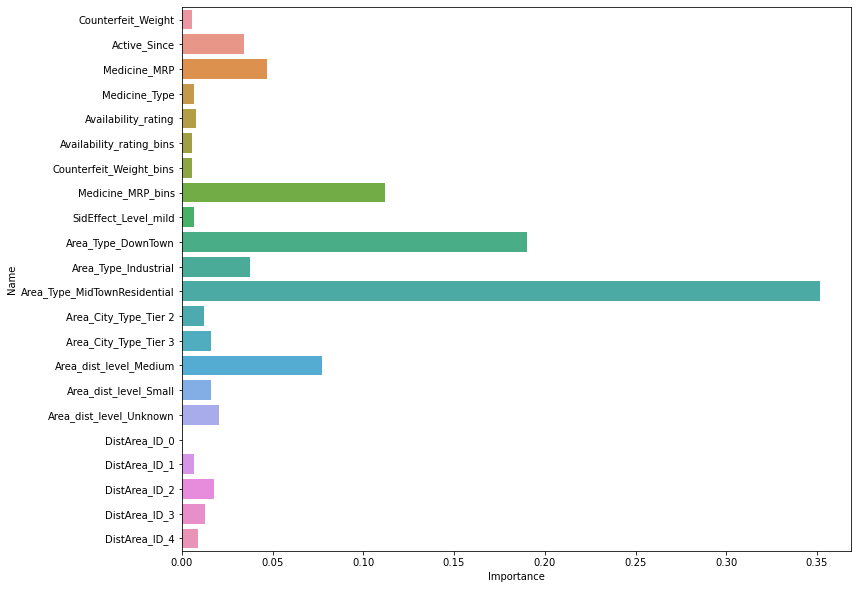

In [1490]:
feat_imp=pd.DataFrame(list(zip(train_d.columns, xgb_rs_best.feature_importances_)), columns=['Name', 'Importance'])

plt.figure(figsize= (12,10))
sns.barplot(y=feat_imp['Name'], x=feat_imp['Importance'])

feat_imp.sort_values('Importance')

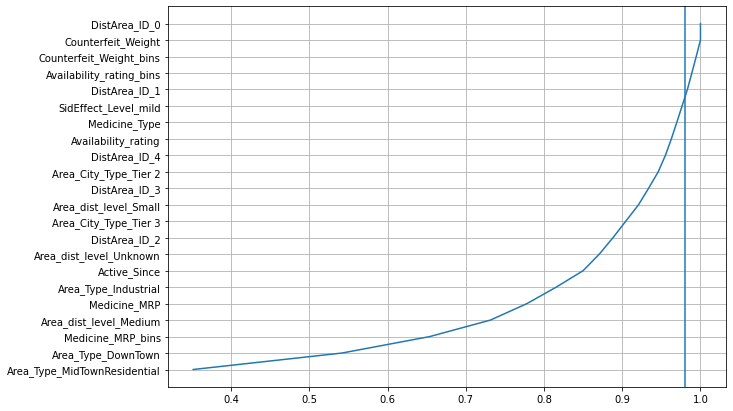

In [1533]:
feat_imp.sort_values('Importance', ascending=False, inplace=True)
importances = feat_imp['Importance']
featuress   = feat_imp['Name']

cum_importance = np.cumsum(importances)
plt.figure(figsize=(10,7))
plt.plot(cum_importance, featuress)
plt.grid()
dashed_line_point  = max(cum_importance)*0.98
plt.axvline(dashed_line_point)

In [1617]:
##Dropping these two variables gave better result, hence we have dropped it earlier while preparing test train
#all_data.drop(['Counterfeit_Weight', 'Availability_rating_bins'] ,axis=1, inplace=True)

Implementing PCA

In [1622]:
##PCA
from sklearn.decomposition import PCA
all_data[all_data['data'] =='train'].shape

(6748, 22)

In [1627]:
all_data_pca = all_data[all_data['data'] =='train'].copy()
del all_data_pca['data']
pca_data = all_data_pca.values

pca=PCA(n_components=21)
pca.fit(pca_data)

var=pca.explained_variance_ratio_
var1=np.cumsum(pca.explained_variance_ratio_*100)
print(var1)

[ 99.99528737  99.99639386  99.99708923  99.99766414  99.99812571
  99.99851587  99.99881432  99.99909611  99.99936213  99.99955847
  99.99971884  99.99984846  99.9999193   99.99996814  99.99999341
 100.         100.         100.         100.         100.
 100.        ]


In [1632]:
target=all_data_pca['Counterfeit_Sales']
pca = PCA(n_components=2)
pca.fit(pca_data)

train_d, test_d, train_dd, test_dd = train_test_split(pca_data , target , test_size = 0.2)

In [1635]:
rfr_best = random_search_forest.best_estimator_
rfr_best.fit(train_d, train_dd)            
predicted_val_rf = rfr_best.predict(test_d)

predicted_val_rf = trgt_scale.inverse_transform(np.array(predicted_val_rf).reshape(-1,1))
test_dd_ipca       = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))

MAE_rf = mean_absolute_error(test_dd_ipca, predicted_val_rf)
print('Mean absolute error : {0}'.format(MAE_rf))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean absolute error : 273.93647177071404


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.2s finished


In [1636]:
xgb_rs_best = xgb_rs.best_estimator_
xgb_rs_best.fit(train_d, train_dd)

predicted_val = xgb_rs_best.predict(test_d)
predicted_val = trgt_scale.inverse_transform(np.array(predicted_val).reshape(-1,1))

test_dd_ipca  = trgt_scale.inverse_transform(np.array(test_dd).reshape(-1,1))

MAE = mean_absolute_error(test_dd_ipca, predicted_val)

#Calculating Score
print('Mean absolute error : {0}'.format(MAE))

Mean absolute error : 59.18393174992765


In [1639]:
xgb_rs_best.fit(x_train, y_train) 
prd_val=xgb_rs_best.predict(x_test)
prd_val = trgt_scale.inverse_transform(np.array(prd_val).reshape(-1,1))

pd.DataFrame(prd_val).to_csv("D:\Rishabh\Python\P3 Data\Rishabh_Singh_P3_part2.csv", index=False)